# Steam Ratings Code

Load and clean/engineer features for our Steam ratings dataset; train and evaluate a Lasso regression and Adaboost regressor.

In [1]:
%matplotlib inline
import dataset
import numpy as np
import pandas as pd
import spacy
import sklearn.ensemble
import sklearn.feature_extraction
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.tree
import pydotplus
import random
import pickle
import gzip
import math

from IPython.display import Image
from io import StringIO
from tqdm import tqdm

random.seed(0)

# Load data and identify useful features

Connect to the database and query the data.

In [2]:
db = dataset.connect('postgres:///steam')

In [3]:
query = '''
SELECT
  steam_app_id,
  game_name,
  reviews_last_30_days,
  pct_positive_reviews_last_30_days,
  reviews_all_time,
  pct_positive_reviews_all_time,
  release_date,
  title,
  developer,
  publisher,
  num_achievements,
  full_price,
  metacritic_score,
  genres,
  details,
  tags
FROM
  game_crawl_view
WHERE
  is_dlc = FALSE
  AND pct_positive_reviews_all_time IS NOT NULL
  AND short_description IS NOT NULL
  AND short_description != ''
  AND long_description IS NOT NULL
  AND long_description != ''
ORDER BY
  steam_app_id;
'''

data = [r for r in db.query(query)]
data_df = pd.DataFrame(data)
data_df.index = data_df['steam_app_id']
data_df.drop('steam_app_id', axis=1, inplace=True)
display(data_df.head())
display(data_df.shape)

,game_name,reviews_last_30_days,pct_positive_reviews_last_30_days,reviews_all_time,pct_positive_reviews_all_time,release_date,title,developer,publisher,num_achievements,full_price,metacritic_score,genres,details,tags
steam_app_id,,,,,,,,,,,,,,,
10,Counter-Strike,745.0,96.0,39394,97.0,2000-11-01,Counter-Strike,Valve,Valve,NaN,9.99,88.0,[Action],"[Multi-player, Valve Anti-Cheat enabled]","[Action, FPS, Multiplayer, Shooter, Classic, T..."
20,Team Fortress Classic,35.0,71.0,1842,81.0,1999-04-01,Team Fortress Classic,Valve,Valve,NaN,4.99,NaN,[Action],"[Multi-player, Valve Anti-Cheat enabled]","[Classic, Shooter, Class-Based, Team-Based, Fi..."
30,Day of Defeat,24.0,83.0,1277,88.0,2003-05-01,Day of Defeat,Valve,Valve,NaN,4.99,79.0,[Action],"[Multi-player, Valve Anti-Cheat enabled]","[FPS, World War II, Multiplayer, Action, Shoot..."
40,Deathmatch Classic,NaN,NaN,545,82.0,2001-06-01,Deathmatch Classic,Valve,Valve,NaN,4.99,NaN,[Action],"[Multi-player, Valve Anti-Cheat enabled]","[Action, FPS, Multiplayer, Classic, Shooter, F..."
50,Half-Life: Opposing Force,48.0,95.0,2585,95.0,1999-11-01,Half-Life: Opposing Force,Gearbox Software,Valve,NaN,4.99,NaN,[Action],"[Single-player, Multi-player, Valve Anti-Cheat...","[FPS, Action, Sci-fi, Singleplayer, Classic, S..."


(11239, 15)

Create dummies for list variables (such as genre; each game can have multiple genres, where we really just need one-hot encodings for all genres).

In [4]:
def create_dummies_from_list(df, col, db_table):
    all_values = {r['descr'] for r in db[db_table].find()}
    agg_series = df[col].apply(lambda x: [] if x is None else x)
    df.drop(col, axis=1, inplace=True)
    for val in all_values:
        df['{}|{}'.format(col, val)] = agg_series.apply(lambda x: val in x)

create_dummies_from_list(data_df, 'genres', 'steam_genre')
create_dummies_from_list(data_df, 'details', 'steam_game_detail')
create_dummies_from_list(data_df, 'tags', 'steam_tag')

display(data_df.head())
display(data_df.shape)

,game_name,reviews_last_30_days,pct_positive_reviews_last_30_days,reviews_all_time,pct_positive_reviews_all_time,release_date,title,developer,publisher,num_achievements,...,tags|Typing,tags|Mars,tags|Gun Customization,tags|Alternate History,tags|Cinematic,tags|Loot,tags|War,tags|Mod,tags|Cult Classic,tags|TrackIR
steam_app_id,,,,,,,,,,,,,,,,,,,,,
10,Counter-Strike,745.0,96.0,39394,97.0,2000-11-01,Counter-Strike,Valve,Valve,NaN,...,False,False,False,False,False,False,False,False,False,False
20,Team Fortress Classic,35.0,71.0,1842,81.0,1999-04-01,Team Fortress Classic,Valve,Valve,NaN,...,False,False,False,False,False,False,False,True,False,False
30,Day of Defeat,24.0,83.0,1277,88.0,2003-05-01,Day of Defeat,Valve,Valve,NaN,...,False,False,False,False,False,False,True,False,False,False
40,Deathmatch Classic,NaN,NaN,545,82.0,2001-06-01,Deathmatch Classic,Valve,Valve,NaN,...,False,False,False,False,False,False,False,False,False,False
50,Half-Life: Opposing Force,48.0,95.0,2585,95.0,1999-11-01,Half-Life: Opposing Force,Gearbox Software,Valve,NaN,...,False,False,False,False,False,False,False,False,False,False


(11239, 409)

Create dummies for regular categorical variables.  However, these have way too many distinct values, so only save the one-hot encodings for values more frequent than 10 (i.e., only make a specific publisher a feature if they've published >= 10 games in our dataset).

In [5]:
def create_dummies(df, col, min_num=10):
    series = df[col]
    df.drop(col, axis=1, inplace=True)
    
    counts = series.value_counts()
    filtered_counts = counts[counts >= min_num]
    filtered_series = series.apply(lambda x: x if x in filtered_counts.index else np.NaN)
    return df.merge(pd.get_dummies(filtered_series, prefix=col, prefix_sep='|'), left_index=True, right_index=True)

data_df = create_dummies(data_df, 'publisher')
data_df = create_dummies(data_df, 'developer')

Some variables have missing values that should represent 0.  Make that replacement here.

In [6]:
for col in ['reviews_last_30_days', 'num_achievements', 'full_price']:
    data_df[col].fillna(value=0, inplace=True)

The timestamp probably won't be a useful feature, but convert it to a float so it's at least usable in case it becomes one.  There are only a few games with null release date (38); drop them to avoid fitting the model on a null timestamp.

In [7]:
data_df = data_df[~pd.isnull(data_df['release_date'])]

# Divide by 10^9 to get seconds since the epoch instead of nanoseconds
data_df.loc[:, 'release_date'] = (pd.to_datetime(data_df['release_date']).astype(np.int64) / 10**9).astype(np.float64)

Convert integer continuous variables to floats so they work well with our models later.

In [8]:
data_df.loc[:, 'reviews_all_time'] = data_df['reviews_all_time'].astype(np.float64)

Remove the outcome and other related vars from the set of features to prepare for analysis.

In [9]:
y = data_df['pct_positive_reviews_all_time']

for col in ('pct_positive_reviews_last_30_days', 'pct_positive_reviews_all_time',
            'game_name', 'title', 'metacritic_score'):
    data_df.drop(col, axis=1, inplace=True)

In [10]:
df_train, df_test, y_train, y_test = sklearn.model_selection.train_test_split(data_df, y, test_size=0.2,
                                                                              random_state=1337)

Final feature set for analysis (until text features are added):

In [11]:
display(df_train.shape)
display(df_test.shape)

(8960, 614)

(2241, 614)

# Use decision trees to find optimal bins for all continuous predictors

When dealing with continuous variables that have a nonlinear relationship with the outcome, sometimes setting up discrete bins is the best way to utilize the feature in the model.  Deciding how to best bin the variables can be challenging; unsupervised methods, such as equal intervals or equal interval width, can easily miss patterns in the data.

One systematic way to develop optimal bins is to train a decision tree for each predictor.  The split criteria of the decision tree will empirically determine the best way to divide up the variable values.  We do that here for all continuous variables (and will use this technique again when we add word counts, which are technically discrete but will be treated as continuous due to their many possible values).

In [12]:
def display_cv_results(grid_search, max_rows=10):
    display(pd.DataFrame(grid_search.cv_results_)
                .sort_values('mean_test_score', ascending=False)[:max_rows])

def find_optimal_bins(df_train, y_train, variable, display_report=False):
    '''
    Given our data and a variable, do the following:
    
    1) Train a cross-validated decision tree using that variable and the outcome only
    2) Return the trained tree, which can be used to apply the same bins onto new data.
    '''
    pipeline = sklearn.pipeline.Pipeline((
        ('scaler', sklearn.preprocessing.MinMaxScaler()),
        ('clf', sklearn.tree.DecisionTreeRegressor(presort=True))
    ))
    
    param_grid = {
        'clf__criterion': ('mse', 'friedman_mse', 'mae'),
        'clf__min_impurity_decrease': (8e-1, 7e-1, 6.5e-1, 6.25e-1, 6e-1, 5.75e-1, 5.5e-1,
                                       5e-1, 4.75e-1, 4.5e-1, 4.25e-1, 4e-1, 3.75e-1, 3.5e-1,
                                       3e-1, 2.5e-1, 2.25e-1, 2e-1, 1.75e-1,
                                       1.5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3),
    }
    
    grid_search = sklearn.model_selection.GridSearchCV(
        pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
        n_jobs=-1, cv=3, return_train_score=True)
    
    X = df_train[[variable]].as_matrix()
    y = y_train.as_matrix()
    grid_search.fit(X, y)
    
    if display_report:
        display_cv_results(grid_search)
    
    return grid_search.best_estimator_


def apply_bins(pipeline, variable, df):
    '''
    Given a trained model, apply its bins to the column identified in the given dataset and
    return the result.
    '''
    transformed_values = pipeline.named_steps.scaler.transform(df[[variable]])
    return pipeline.named_steps.clf.apply(transformed_values)

def draw_tree(clf, variable):
    dot_data = StringIO()
    
    sklearn.tree.export_graphviz(clf, out_file=dot_data,
                                filled=True, rounded=True,
                                special_characters=True,
                                feature_names=['variable'],
                                node_ids=True)
    
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    display(Image(graph.create_png()))

Run the bin-finding for all the continuous vars.  Output the CV results so we can expand the parameter grid if needed, and visualize each tree so we can confirm they make sense.

Training tree for full_price


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
18,0.001757,0.000418,-368.300753,-366.586102,mse,0.175,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-368.734675,-366.281643,-372.026630,-365.165469,-364.139559,-368.311195,0.000629,0.000176,3.234383,1.302157
17,0.001049,0.000353,-368.431029,-366.798369,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",2,-369.125462,-366.918443,-372.026630,-365.165469,-364.139559,-368.311195,0.000274,0.000128,3.257028,1.287041
19,0.001031,0.000342,-368.593895,-366.423731,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",3,-369.579816,-365.964472,-372.060818,-364.995525,-364.139559,-368.311195,0.000054,0.000084,3.308057,1.392026
13,0.000783,0.000248,-368.658233,-367.404195,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-369.719035,-367.183813,-371.945829,-365.676938,-364.308378,-369.351835,0.000011,0.000003,3.206864,1.508342
11,0.000778,0.000243,-368.658233,-367.404195,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-369.719035,-367.183813,-371.945829,-365.676938,-364.308378,-369.351835,0.000016,0.000006,3.206864,1.508342
12,0.000803,0.000250,-368.658233,-367.404195,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-369.719035,-367.183813,-371.945829,-365.676938,-364.308378,-369.351835,0.000020,0.000001,3.206864,1.508342
15,0.000794,0.000251,-368.674103,-367.117176,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",7,-369.125462,-366.918443,-372.296985,-365.373659,-364.598497,-369.059426,0.000023,0.000007,3.158973,1.511256
16,0.000792,0.000249,-368.692532,-367.039341,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-369.125462,-366.918443,-372.296985,-365.373659,-364.653796,-368.825920,0.000017,0.000005,3.135215,1.411970
14,0.000809,0.000254,-368.775298,-367.303102,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",9,-369.719035,-367.183813,-372.296985,-365.373659,-364.308378,-369.351835,0.000043,0.000010,3.328830,1.626272
21,0.001237,0.000376,-369.086104,-365.609842,mse,0.05,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",10,-369.608204,-364.922158,-373.076614,-364.283693,-364.571982,-367.623676,0.000143,0.000114,3.491481,1.447654


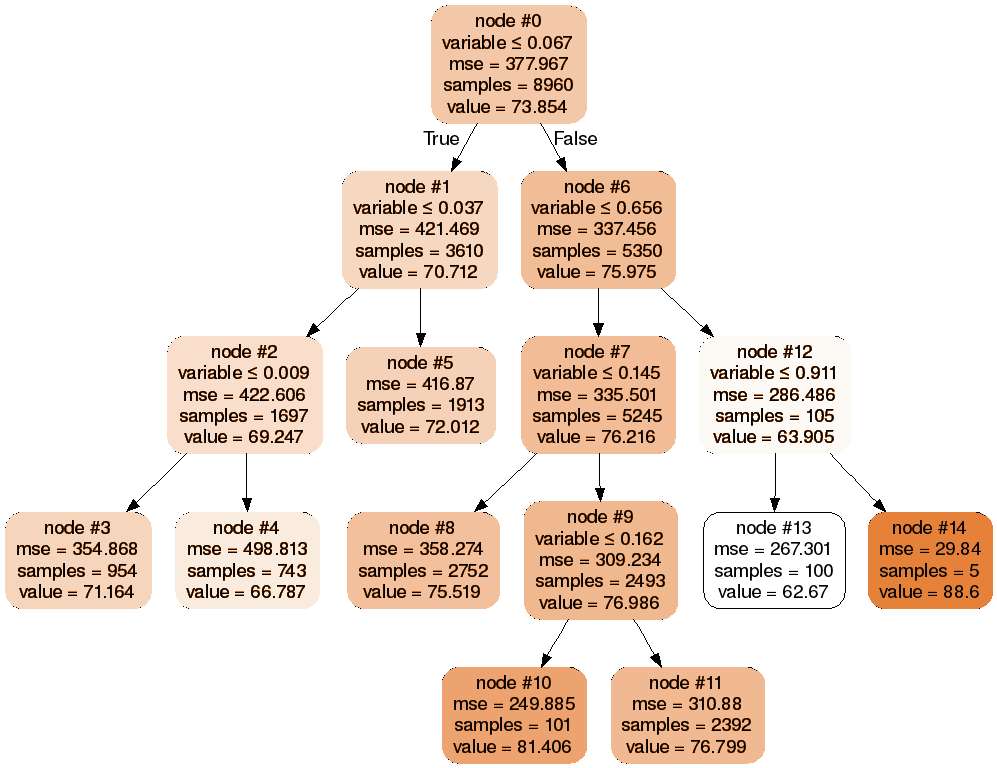

Training tree for reviews_last_30_days


/home/jason/.pyenv/versions/miniconda3-latest/envs/csc522_project/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
19,0.000723,0.000234,-359.076986,-357.937635,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-358.828644,-357.831546,-365.310144,-355.099835,-353.090166,-360.881525,0.000040,0.000004,4.991736,2.361557
13,0.000679,0.000233,-359.084231,-358.386695,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",2,-358.657965,-358.625092,-365.486878,-355.277876,-353.105848,-361.257117,0.000015,0.000005,5.063374,2.446828
18,0.000852,0.000252,-359.107052,-357.989293,mse,0.175,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",3,-358.828644,-357.831546,-365.310144,-355.099835,-353.180384,-361.036496,0.000104,0.000011,4.955728,2.426197
14,0.000706,0.000235,-359.166871,-358.273925,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-358.905857,-358.286781,-365.486878,-355.277876,-353.105848,-361.257117,0.000042,0.000005,5.057762,2.441032
20,0.000732,0.000232,-359.189698,-357.517594,mse,0.1,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",5,-359.002943,-357.121398,-365.069502,-354.863978,-353.494743,-360.567405,0.000023,0.000002,4.727089,2.345207
16,0.000684,0.000231,-359.196325,-358.183523,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",6,-358.994210,-358.015575,-365.486878,-355.277876,-353.105848,-361.257117,0.000012,0.000003,5.056414,2.443902
15,0.000697,0.000242,-359.196325,-358.183523,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",6,-358.994210,-358.015575,-365.486878,-355.277876,-353.105848,-361.257117,0.000014,0.000009,5.056414,2.443902
17,0.000699,0.000237,-359.221165,-358.109982,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-358.994210,-358.015575,-365.486878,-355.277876,-353.180384,-361.036496,0.000010,0.000006,5.026528,2.351894
11,0.000683,0.000234,-359.545388,-358.508474,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",9,-358.657965,-358.625092,-365.486878,-355.277876,-354.489628,-361.622453,0.000009,0.000003,4.533132,2.591475
12,0.000687,0.000262,-359.545388,-358.508474,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",9,-358.657965,-358.625092,-365.486878,-355.277876,-354.489628,-361.622453,0.000021,0.000037,4.533132,2.591475


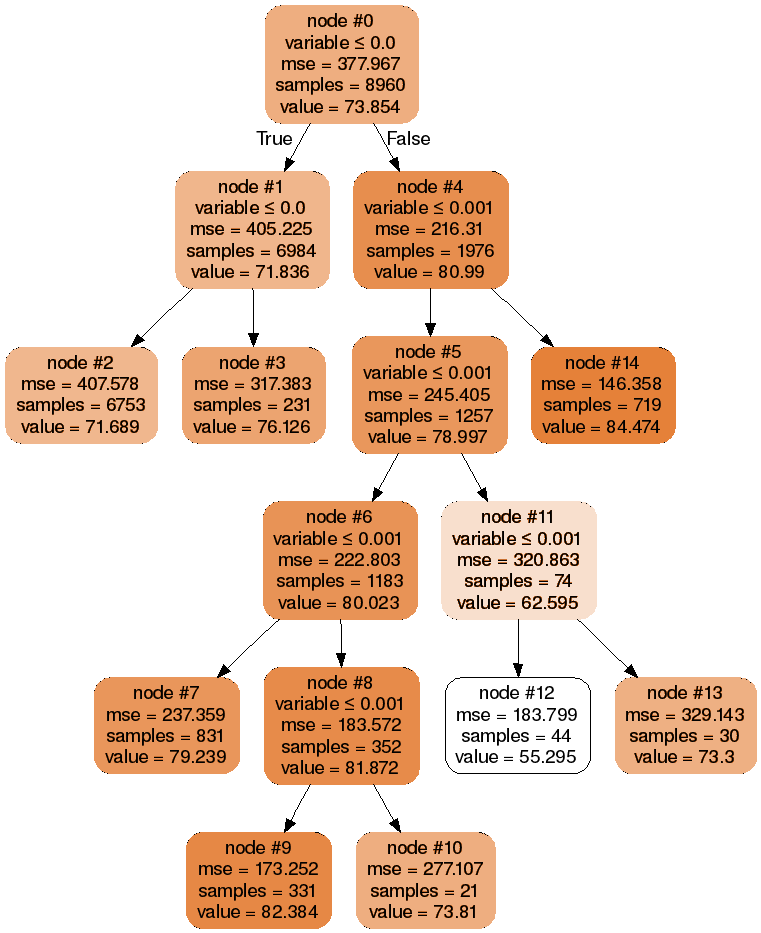

Training tree for reviews_all_time


/home/jason/.pyenv/versions/miniconda3-latest/envs/csc522_project/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,0.001481,0.000394,-355.037326,-353.156703,mse,0.7,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-353.173935,-354.347959,-359.610978,-350.724084,-352.326159,-354.398068,0.000277,0.000129,3.252795,1.720243
3,0.001649,0.000291,-355.037326,-353.156703,mse,0.625,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-353.173935,-354.347959,-359.610978,-350.724084,-352.326159,-354.398068,0.000867,0.000050,3.252795,1.720243
2,0.001551,0.000433,-355.037326,-353.156703,mse,0.65,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-353.173935,-354.347959,-359.610978,-350.724084,-352.326159,-354.398068,0.000252,0.000199,3.252795,1.720243
0,0.002562,0.000541,-355.369729,-353.399678,mse,0.8,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-353.173935,-354.347959,-360.608074,-351.453007,-352.326159,-354.398068,0.000770,0.000052,3.720512,1.376656
4,0.001090,0.000279,-355.597411,-352.951738,mse,0.6,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",5,-354.854000,-353.733063,-359.610978,-350.724084,-352.326159,-354.398068,0.000019,0.000013,3.020041,1.598414
5,0.001053,0.000260,-355.597411,-352.951738,mse,0.575,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",5,-354.854000,-353.733063,-359.610978,-350.724084,-352.326159,-354.398068,0.000031,0.000006,3.020041,1.598414
9,0.001040,0.000270,-356.039058,-352.764213,mse,0.45,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",7,-354.854000,-353.733063,-359.610978,-350.724084,-353.651397,-353.835493,0.000028,0.000012,2.573208,1.443195
12,0.001043,0.000270,-356.039058,-352.764213,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",7,-354.854000,-353.733063,-359.610978,-350.724084,-353.651397,-353.835493,0.000038,0.000010,2.573208,1.443195
10,0.001100,0.000283,-356.039058,-352.764213,mse,0.425,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",7,-354.854000,-353.733063,-359.610978,-350.724084,-353.651397,-353.835493,0.000006,0.000003,2.573208,1.443195
11,0.001068,0.000269,-356.039058,-352.764213,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",7,-354.854000,-353.733063,-359.610978,-350.724084,-353.651397,-353.835493,0.000015,0.000006,2.573208,1.443195


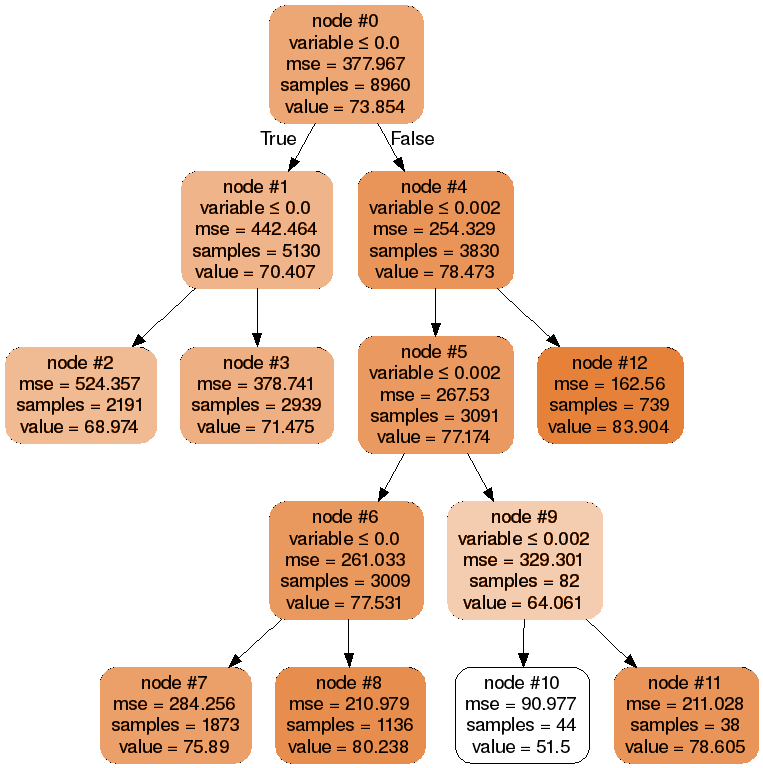

Training tree for release_date


/home/jason/.pyenv/versions/miniconda3-latest/envs/csc522_project/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
7,0.005246,0.000287,-373.765297,-368.680058,mse,0.5,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-373.984885,-366.276107,-380.734020,-366.475988,-366.574580,-373.288079,0.005680,0.000025,5.782491,3.259384
4,0.007374,0.000309,-373.912911,-370.726216,mse,0.6,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",2,-374.333950,-370.792000,-380.734020,-366.475988,-366.668337,-374.910660,0.005317,0.000043,5.749845,3.443754
5,0.003459,0.000358,-373.987527,-370.337111,mse,0.575,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",3,-374.178466,-370.204048,-380.734020,-366.475988,-367.047771,-374.331297,0.000854,0.000070,5.588863,3.208296
6,0.005184,0.000331,-374.025952,-369.370295,mse,0.55,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-374.293730,-367.303598,-380.734020,-366.475988,-367.047771,-374.331297,0.002850,0.000040,5.590440,3.524192
8,0.001267,0.002111,-374.083566,-367.975514,mse,0.475,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",5,-373.786827,-365.786110,-381.886778,-364.852354,-366.574580,-373.288079,0.000047,0.002594,6.254525,3.775843
0,0.003333,0.000951,-374.091925,-371.861243,mse,0.8,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",6,-374.333950,-370.792000,-381.271003,-369.881068,-366.668337,-374.910660,0.002295,0.000559,5.963803,2.188098
1,0.001235,0.000745,-374.091925,-371.861243,mse,0.7,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",6,-374.333950,-370.792000,-381.271003,-369.881068,-366.668337,-374.910660,0.000111,0.000579,5.963803,2.188098
3,0.001702,0.000607,-374.091925,-371.861243,mse,0.625,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",6,-374.333950,-370.792000,-381.271003,-369.881068,-366.668337,-374.910660,0.000571,0.000308,5.963803,2.188098
2,0.001178,0.000285,-374.091925,-371.861243,mse,0.65,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",6,-374.333950,-370.792000,-381.271003,-369.881068,-366.668337,-374.910660,0.000066,0.000017,5.963803,2.188098
14,0.005400,0.000292,-374.200921,-365.571429,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",10,-375.878677,-364.306748,-381.137928,-360.164740,-365.583274,-372.242799,0.005746,0.000025,6.459873,5.011283


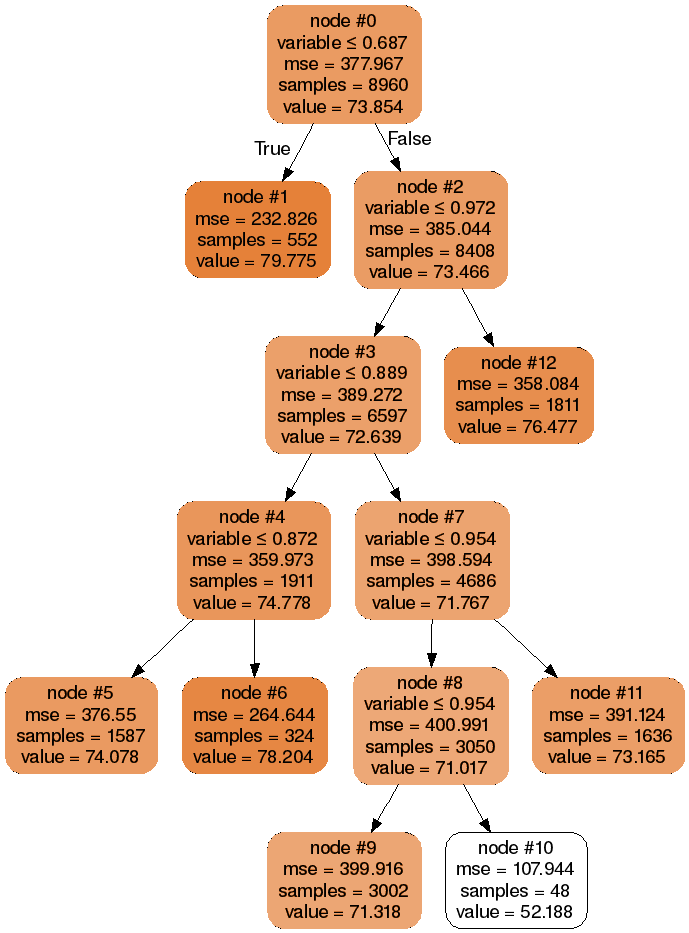

Training tree for num_achievements


/home/jason/.pyenv/versions/miniconda3-latest/envs/csc522_project/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
19,0.000988,0.000289,-364.971694,-361.559206,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-360.323466,-364.324149,-375.651588,-356.131136,-358.938007,-364.222331,0.000015,0.000012,7.573607,3.838450
18,0.000924,0.000275,-365.012755,-362.098837,mse,0.175,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",2,-360.295506,-365.619747,-375.651588,-356.131136,-359.089187,-364.545627,0.000077,0.000011,7.539521,4.242524
2,0.000959,0.000350,-365.158856,-363.439198,mse,0.65,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",3,-359.708899,-366.190407,-376.382572,-357.751503,-359.383162,-366.375683,0.000125,0.000111,7.938144,4.022519
3,0.000768,0.000256,-365.158856,-363.439198,mse,0.625,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",3,-359.708899,-366.190407,-376.382572,-357.751503,-359.383162,-366.375683,0.000017,0.000009,7.938144,4.022519
4,0.000835,0.000279,-365.158856,-363.439198,mse,0.6,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",3,-359.708899,-366.190407,-376.382572,-357.751503,-359.383162,-366.375683,0.000025,0.000004,7.938144,4.022519
5,0.000767,0.000244,-365.158856,-363.439198,mse,0.575,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",3,-359.708899,-366.190407,-376.382572,-357.751503,-359.383162,-366.375683,0.000018,0.000006,7.938144,4.022519
16,0.008763,0.000264,-365.270583,-362.796177,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",7,-360.295506,-365.619747,-376.212350,-356.897444,-359.301895,-365.871339,0.011168,0.000009,7.748270,4.172299
15,0.000870,0.000278,-365.297666,-362.964291,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-360.295506,-365.619747,-376.212350,-356.897444,-359.383162,-366.375683,0.000033,0.000010,7.727474,4.300995
17,0.000907,0.000266,-365.307342,-362.227991,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",9,-360.295506,-365.619747,-376.268165,-356.326253,-359.356364,-364.737973,0.000073,0.000016,7.760597,4.188657
8,0.000781,0.000247,-365.354413,-363.248978,mse,0.475,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",10,-360.295506,-365.619747,-376.382572,-357.751503,-359.383162,-366.375683,0.000038,0.000003,7.807627,3.899532


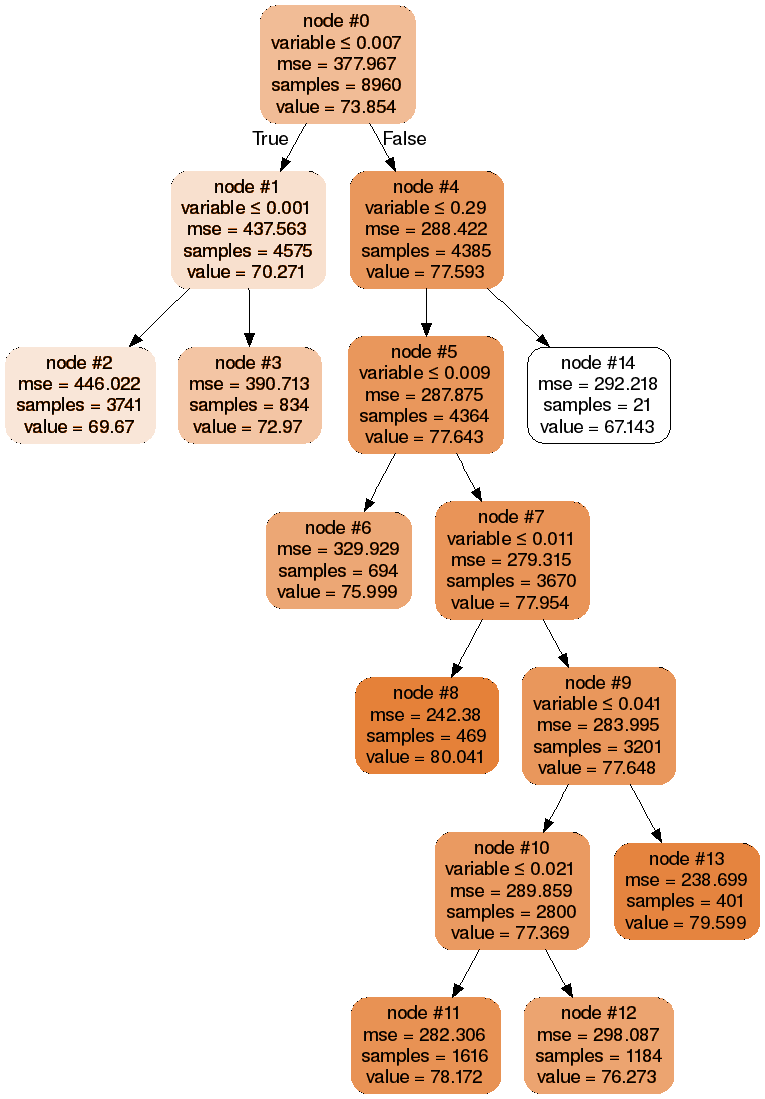

/home/jason/.pyenv/versions/miniconda3-latest/envs/csc522_project/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
continuous_vars = (
    'full_price',
    'reviews_last_30_days',
    'reviews_all_time',
    'release_date',
    'num_achievements',
)

pipelines = {}

for var in continuous_vars:
    print('Training tree for {}'.format(var))
    pipeline = find_optimal_bins(df_train, y_train, var, display_report=True)
    pipelines[var] = pipeline
    clf = pipeline.named_steps.clf
    draw_tree(clf, var)
    
    for df in (df_train, df_test):
        df['{}_binned'.format(var)] = apply_bins(pipeline, var, df)

# Apply various transformations to continuous variables

Apply some common transformations to continuous variables in case they have a nonlinear relationship with the outcome.

In [14]:
for var in continuous_vars:
    for df in (df_train, df_test):
        df.loc[:, '{}_squared'.format(var)] = np.square(df[var])
        # Add two for log transform to prevent numeric warnings
        df.loc[:, '{}_log'.format(var)] = np.log(df[var]+2)
        df.loc[:, '{}_loglog'.format(var)] = np.log(df['{}_log'.format(var)])
        df.loc[:, '{}_sqrt'.format(var)] = np.sqrt(df[var])
        df.loc[:, '{}_indicator'.format(var)] = df[var].apply(lambda x: 1 if x > 0
                                                       else 0)
        
        for winsor_pctile in (90, 95, 99):
            winsor_threshold = np.percentile(df[var], winsor_pctile)
            df.loc[:, '{}_winsor{}'.format(var, winsor_pctile)] = df[var].apply(
                lambda x: winsor_threshold if x > winsor_threshold
                else x)

/home/jason/.pyenv/versions/miniconda3-latest/envs/csc522_project/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/jason/.pyenv/versions/miniconda3-latest/envs/csc522_project/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Add word count features from text data

Pull in the free text features from the description for each game we're including.

In [15]:
query = '''
SELECT
  steam_app_id,
  short_description,
  long_description
FROM
  game_crawl_view
WHERE
  is_dlc = FALSE
  AND pct_positive_reviews_all_time IS NOT NULL
  AND short_description IS NOT NULL
  AND short_description != ''
  AND long_description IS NOT NULL
  AND long_description != ''
  AND release_date IS NOT NULL
ORDER By
  steam_app_id;
'''

text_data = [r for r in db.query(query)]
text_df = pd.DataFrame(text_data)
text_df.index = text_df['steam_app_id']
text_df.drop('steam_app_id', axis=1, inplace=True)
display(text_df.head())
display(text_df.shape)

,short_description,long_description
steam_app_id,,
10,Play the world's number 1 online action game. ...,ABOUT THIS GAME\nPlay the world's number 1 onl...
20,One of the most popular online action games of...,ABOUT THIS GAME\nOne of the most popular onlin...
30,Enlist in an intense brand of Axis vs. Allied ...,ABOUT THIS GAME\nEnlist in an intense brand of...
40,Enjoy fast-paced multiplayer gaming with Death...,ABOUT THIS GAME\nEnjoy fast-paced multiplayer ...
50,Return to the Black Mesa Research Facility as ...,ABOUT THIS GAME\nReturn to the Black Mesa Rese...


(11201, 2)

Apply spacy's tokenization routine to the short and long descriptions to generate word counts.

In [16]:
nlp = spacy.load('en')

def tokenize(doc):
    parsed = nlp(doc, tag=False, parse=False)
    tokens = []

    for token in parsed:
        # exclude stopwords and non-alphabetic tokens
        if not token.is_stop and token.is_alpha:
            tokens.append(token.lower_)
            
            # If spacy provides a lemma for the word (a shortened
            # form of the word so that similar words like "buy" and "buying"
            # are combined), use it
            if token.lemma_ != '':
                tokens.append(token.lemma_ + '_spacylemma')    

    return tokens

short_vectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer=tokenize, min_df=1e-2)
long_vectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer=tokenize, min_df=1e-2)
short_features = short_vectorizer.fit_transform(text_df['short_description']).toarray()
long_features = long_vectorizer.fit_transform(text_df['long_description']).toarray()
short_feature_names = ['short_description|{}'.format(f) for f in short_vectorizer.get_feature_names()]
long_feature_names = ['long_description|{}'.format(f) for f in long_vectorizer.get_feature_names()]

In [17]:
short_features_df = pd.DataFrame(short_features, columns=short_feature_names, index=text_df.index,
                                dtype=np.float64)
long_features_df = pd.DataFrame(long_features, columns=long_feature_names, index=text_df.index,
                               dtype=np.float64)

Apply the new features across the old train/test split.

In [18]:
text_df_train = df_train.copy()
text_df_test = df_test.copy()

for merge_df in (short_features_df, long_features_df):
    text_df_train = text_df_train.merge(merge_df, left_index=True, right_index=True, how='inner')
    text_df_test = text_df_test.merge(merge_df, left_index=True, right_index=True, how='inner')

display(text_df_train.shape)
display(text_df_test.shape)

(8960, 2836)

(2241, 2836)

# Use decision trees to find optimal bins for text word counts

This will be a slimmed-down version of the process we used before, since the massive number of features doesn't allow for thorough examination of the parameter grids for all of them.  Display a report for a small random sample of the variables for verification, but run through the rest without a report.

Training tree for short_description|abilities (0/2177)
Training tree for short_description|acclaimed (1/2177)
Training tree for short_description|action (2/2177)
Training tree for short_description|adventure (3/2177)
Training tree for short_description|adventures (4/2177)
Training tree for short_description|alien (5/2177)
Training tree for short_description|ancient (6/2177)
Training tree for short_description|arcade (7/2177)
Training tree for short_description|arena (8/2177)
Training tree for short_description|army (9/2177)
Training tree for short_description|art (10/2177)
Training tree for short_description|attack (11/2177)
Training tree for short_description|available (12/2177)
Training tree for short_description|award (13/2177)
Training tree for short_description|away (14/2177)
Training tree for short_description|based (15/2177)
Training tree for short_description|battle (16/2177)
Training tree for short_description|battles (17/2177)
Training tree for short_description|beautiful (18

Training tree for short_description|jump (154/2177)
Training tree for short_description|king (155/2177)
Training tree for short_description|kingdom (156/2177)
Training tree for short_description|known (157/2177)
Training tree for short_description|land (158/2177)
Training tree for short_description|lead (159/2177)
Training tree for short_description|learn (160/2177)
Training tree for short_description|legendary (161/2177)
Training tree for short_description|level (162/2177)
Training tree for short_description|levels (163/2177)
Training tree for short_description|life (164/2177)
Training tree for short_description|light (165/2177)


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.001593,0.000620,-378.058311,-377.949079,mse,0.8,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000057,0.000046,5.110782,2.57062
11,0.000527,0.000215,-378.058311,-377.949079,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000048,0.000008,5.110782,2.57062
19,0.000519,0.000335,-378.058311,-377.949079,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000037,0.000166,5.110782,2.57062
1,0.001433,0.000409,-378.058311,-377.949079,mse,0.7,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.001131,0.000225,5.110782,2.57062
17,0.000534,0.000248,-378.058311,-377.949079,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000045,0.000048,5.110782,2.57062
16,0.000488,0.000214,-378.058311,-377.949079,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000008,0.000002,5.110782,2.57062
15,0.000539,0.000226,-378.058311,-377.949079,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000073,0.000004,5.110782,2.57062
14,0.000503,0.000356,-378.058311,-377.949079,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000036,0.000184,5.110782,2.57062
13,0.000492,0.000210,-378.058311,-377.949079,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000038,0.000008,5.110782,2.57062
12,0.000485,0.000349,-378.058311,-377.949079,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000015,0.000201,5.110782,2.57062


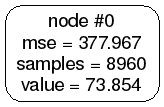

Training tree for short_description|like (166/2177)
Training tree for short_description|little (167/2177)
Training tree for short_description|live (168/2177)
Training tree for short_description|local (169/2177)
Training tree for short_description|long (170/2177)
Training tree for short_description|lost (171/2177)
Training tree for short_description|love (172/2177)
Training tree for short_description|magic (173/2177)
Training tree for short_description|magical (174/2177)
Training tree for short_description|man (175/2177)
Training tree for short_description|manage (176/2177)
Training tree for short_description|management (177/2177)
Training tree for short_description|massive (178/2177)
Training tree for short_description|master (179/2177)
Training tree for short_description|mechanics (180/2177)
Training tree for short_description|mind (181/2177)
Training tree for short_description|mission (182/2177)
Training tree for short_description|missions (183/2177)
Training tree for short_descripti

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
15,0.000554,0.000225,-377.551049,-377.434995,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.759538,-377.315334,-383.7365,-374.33061,-371.154968,-380.659041,3.424681e-05,0.000014,5.138361,2.584956
10,0.000566,0.000227,-377.551049,-377.434995,mse,0.425,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.759538,-377.315334,-383.7365,-374.33061,-371.154968,-380.659041,6.252418e-05,0.000018,5.138361,2.584956
18,0.000501,0.000242,-377.551049,-377.434995,mse,0.175,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.759538,-377.315334,-383.7365,-374.33061,-371.154968,-380.659041,5.775878e-06,0.000041,5.138361,2.584956
17,0.000521,0.000221,-377.551049,-377.434995,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.759538,-377.315334,-383.7365,-374.33061,-371.154968,-380.659041,4.495664e-07,0.000004,5.138361,2.584956
16,0.000602,0.000253,-377.551049,-377.434995,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.759538,-377.315334,-383.7365,-374.33061,-371.154968,-380.659041,1.168947e-04,0.000033,5.138361,2.584956
14,0.000985,0.000325,-377.551049,-377.434995,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.759538,-377.315334,-383.7365,-374.33061,-371.154968,-380.659041,6.044285e-04,0.000152,5.138361,2.584956
13,0.000557,0.000241,-377.551049,-377.434995,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.759538,-377.315334,-383.7365,-374.33061,-371.154968,-380.659041,9.529455e-06,0.000030,5.138361,2.584956
12,0.000546,0.000223,-377.551049,-377.434995,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.759538,-377.315334,-383.7365,-374.33061,-371.154968,-380.659041,5.007812e-05,0.000014,5.138361,2.584956
11,0.000513,0.000213,-377.551049,-377.434995,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.759538,-377.315334,-383.7365,-374.33061,-371.154968,-380.659041,5.520933e-06,0.000006,5.138361,2.584956
9,0.000781,0.000263,-377.771123,-377.580221,mse,0.45,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",10,-378.419685,-377.751012,-383.7365,-374.33061,-371.154968,-380.659041,2.896285e-04,0.000064,5.156682,2.586392


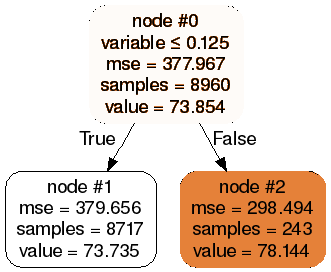

Training tree for short_description|want (303/2177)
Training tree for short_description|war (304/2177)
Training tree for short_description|way (305/2177)
Training tree for short_description|weapon (306/2177)
Training tree for short_description|weapons (307/2177)
Training tree for short_description|welcome (308/2177)
Training tree for short_description|winning (309/2177)
Training tree for short_description|work (310/2177)
Training tree for short_description|world (311/2177)
Training tree for short_description|worlds (312/2177)
Training tree for short_description|year (313/2177)
Training tree for short_description|years (314/2177)
Training tree for short_description|young (315/2177)
Training tree for short_description|zombie (316/2177)
Training tree for long_description|abandoned (317/2177)
Training tree for long_description|abilities (318/2177)
Training tree for long_description|ability (319/2177)
Training tree for long_description|able (320/2177)
Training tree for long_description|acce

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.001804,0.000671,-378.058311,-377.949079,mse,0.8,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,3.224191e-04,0.000199,5.110782,2.57062
11,0.000506,0.000220,-378.058311,-377.949079,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,4.187488e-05,0.000010,5.110782,2.57062
20,0.000469,0.000205,-378.058311,-377.949079,mse,0.1,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,5.947204e-07,0.000002,5.110782,2.57062
19,0.000513,0.000221,-378.058311,-377.949079,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,3.149914e-05,0.000015,5.110782,2.57062
18,0.000526,0.000220,-378.058311,-377.949079,mse,0.175,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,3.465764e-05,0.000010,5.110782,2.57062
16,0.000463,0.000219,-378.058311,-377.949079,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,4.269402e-06,0.000020,5.110782,2.57062
15,0.000494,0.000230,-378.058311,-377.949079,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,4.970149e-05,0.000037,5.110782,2.57062
14,0.000827,0.000243,-378.058311,-377.949079,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,2.560856e-04,0.000027,5.110782,2.57062
13,0.000481,0.000279,-378.058311,-377.949079,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,2.672652e-05,0.000087,5.110782,2.57062
12,0.000596,0.000224,-378.058311,-377.949079,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,5.361221e-05,0.000015,5.110782,2.57062


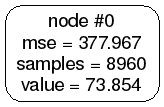

Training tree for long_description|apocalyptic (389/2177)
Training tree for long_description|appear (390/2177)
Training tree for long_description|appearance (391/2177)
Training tree for long_description|approach (392/2177)
Training tree for long_description|arcade (393/2177)
Training tree for long_description|area (394/2177)
Training tree for long_description|areas (395/2177)
Training tree for long_description|arena (396/2177)
Training tree for long_description|arenas (397/2177)
Training tree for long_description|armed (398/2177)
Training tree for long_description|armies (399/2177)
Training tree for long_description|armor (400/2177)
Training tree for long_description|arms (401/2177)
Training tree for long_description|army (402/2177)
Training tree for long_description|array (403/2177)
Training tree for long_description|arsenal (404/2177)


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
15,0.000630,0.000283,-377.441099,-377.214026,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.482112,-377.153952,-383.100279,-374.367906,-371.738998,-380.120219,0.000079,6.025982e-05,4.638185,2.348756
10,0.000650,0.000242,-377.441099,-377.214026,mse,0.425,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.482112,-377.153952,-383.100279,-374.367906,-371.738998,-380.120219,0.000077,1.851325e-05,4.638185,2.348756
20,0.000537,0.000222,-377.441099,-377.214026,mse,0.1,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.482112,-377.153952,-383.100279,-374.367906,-371.738998,-380.120219,0.000037,7.499981e-06,4.638185,2.348756
19,0.000674,0.000230,-377.441099,-377.214026,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.482112,-377.153952,-383.100279,-374.367906,-371.738998,-380.120219,0.000222,2.251510e-05,4.638185,2.348756
18,0.000532,0.000219,-377.441099,-377.214026,mse,0.175,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.482112,-377.153952,-383.100279,-374.367906,-371.738998,-380.120219,0.000038,8.667280e-06,4.638185,2.348756
17,0.000591,0.000227,-377.441099,-377.214026,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.482112,-377.153952,-383.100279,-374.367906,-371.738998,-380.120219,0.000090,1.669611e-05,4.638185,2.348756
16,0.000507,0.000218,-377.441099,-377.214026,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.482112,-377.153952,-383.100279,-374.367906,-371.738998,-380.120219,0.000003,8.485379e-07,4.638185,2.348756
14,0.000539,0.000265,-377.441099,-377.214026,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.482112,-377.153952,-383.100279,-374.367906,-371.738998,-380.120219,0.000030,6.569488e-05,4.638185,2.348756
13,0.000539,0.000218,-377.441099,-377.214026,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.482112,-377.153952,-383.100279,-374.367906,-371.738998,-380.120219,0.000053,5.402986e-06,4.638185,2.348756
12,0.000550,0.000221,-377.441099,-377.214026,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.482112,-377.153952,-383.100279,-374.367906,-371.738998,-380.120219,0.000044,1.337743e-05,4.638185,2.348756


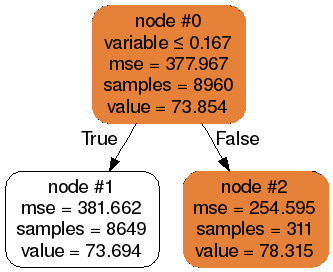

Training tree for long_description|art (405/2177)
Training tree for long_description|artifacts (406/2177)
Training tree for long_description|artificial (407/2177)
Training tree for long_description|artist (408/2177)
Training tree for long_description|arts (409/2177)
Training tree for long_description|artwork (410/2177)
Training tree for long_description|aspect (411/2177)
Training tree for long_description|aspects (412/2177)


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
14,0.000727,0.000252,-377.77805,-377.071635,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.129187,-377.338326,-383.034954,-374.296861,-373.168467,-379.579717,0.000241,4.508696e-05,4.053916,2.164946
16,0.000549,0.000213,-377.77805,-377.071635,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.129187,-377.338326,-383.034954,-374.296861,-373.168467,-379.579717,0.000068,2.032393e-06,4.053916,2.164946
21,0.000536,0.000217,-377.77805,-377.071635,mse,0.05,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.129187,-377.338326,-383.034954,-374.296861,-373.168467,-379.579717,0.000049,5.314590e-06,4.053916,2.164946
20,0.000507,0.000211,-377.77805,-377.071635,mse,0.1,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.129187,-377.338326,-383.034954,-374.296861,-373.168467,-379.579717,0.000026,4.295947e-06,4.053916,2.164946
19,0.000496,0.000225,-377.77805,-377.071635,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.129187,-377.338326,-383.034954,-374.296861,-373.168467,-379.579717,0.000015,2.041323e-05,4.053916,2.164946
18,0.000526,0.000219,-377.77805,-377.071635,mse,0.175,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.129187,-377.338326,-383.034954,-374.296861,-373.168467,-379.579717,0.000031,9.637538e-06,4.053916,2.164946
11,0.000514,0.000218,-377.77805,-377.071635,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.129187,-377.338326,-383.034954,-374.296861,-373.168467,-379.579717,0.000012,6.144645e-06,4.053916,2.164946
12,0.000667,0.000231,-377.77805,-377.071635,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.129187,-377.338326,-383.034954,-374.296861,-373.168467,-379.579717,0.000139,1.743048e-05,4.053916,2.164946
13,0.000514,0.000214,-377.77805,-377.071635,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.129187,-377.338326,-383.034954,-374.296861,-373.168467,-379.579717,0.000005,2.247832e-07,4.053916,2.164946
17,0.000514,0.000228,-377.77805,-377.071635,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.129187,-377.338326,-383.034954,-374.296861,-373.168467,-379.579717,0.000016,1.581969e-05,4.053916,2.164946


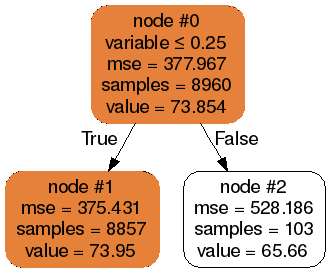

Training tree for long_description|assault (413/2177)
Training tree for long_description|atmosphere (414/2177)
Training tree for long_description|atmospheric (415/2177)
Training tree for long_description|attack (416/2177)
Training tree for long_description|attacks (417/2177)
Training tree for long_description|attempt (418/2177)
Training tree for long_description|attention (419/2177)
Training tree for long_description|audio (420/2177)
Training tree for long_description|authentic (421/2177)
Training tree for long_description|automatically (422/2177)
Training tree for long_description|available (423/2177)
Training tree for long_description|avoid (424/2177)
Training tree for long_description|await (425/2177)
Training tree for long_description|awaits (426/2177)
Training tree for long_description|award (427/2177)
Training tree for long_description|awards (428/2177)
Training tree for long_description|away (429/2177)
Training tree for long_description|awesome (430/2177)
Training tree for long_

Training tree for long_description|check (567/2177)
Training tree for long_description|child (568/2177)
Training tree for long_description|childhood (569/2177)
Training tree for long_description|children (570/2177)


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.000846,0.000421,-378.058311,-377.949079,mse,0.8,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000236,0.000158,5.110782,2.57062
10,0.000530,0.000220,-378.058311,-377.949079,mse,0.425,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000066,0.000019,5.110782,2.57062
1,0.000882,0.000751,-378.058311,-377.949079,mse,0.7,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000235,0.000585,5.110782,2.57062
17,0.000502,0.000213,-378.058311,-377.949079,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000028,0.000007,5.110782,2.57062
15,0.000733,0.000237,-378.058311,-377.949079,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000304,0.000027,5.110782,2.57062
14,0.000678,0.000304,-378.058311,-377.949079,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000177,0.000127,5.110782,2.57062
13,0.000676,0.000216,-378.058311,-377.949079,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000270,0.000009,5.110782,2.57062
12,0.000623,0.000226,-378.058311,-377.949079,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000147,0.000008,5.110782,2.57062
11,0.000612,0.000214,-378.058311,-377.949079,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000105,0.000005,5.110782,2.57062
16,0.000569,0.000261,-378.058311,-377.949079,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000130,0.000057,5.110782,2.57062


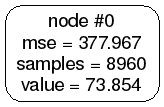

Training tree for long_description|choice (571/2177)
Training tree for long_description|choices (572/2177)


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
21,0.000567,0.000242,-377.973592,-377.709353,mse,0.05,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.855079,-377.286132,-383.812837,-374.748080,-371.250609,-381.093847,0.000058,0.000031,5.166111,2.607876
24,0.000592,0.000246,-377.981442,-377.656469,mse,0.001,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",2,-378.867334,-377.220125,-383.862572,-374.669755,-371.212155,-381.079525,0.000022,0.000036,5.202226,2.634905
37,0.000575,0.000211,-377.982013,-377.656372,friedman_mse,0.375,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",3,-378.869048,-377.219836,-383.862572,-374.669755,-371.212155,-381.079525,0.000040,0.000002,5.202323,2.634921
30,0.000569,0.000227,-377.982013,-377.656372,friedman_mse,0.575,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",3,-378.869048,-377.219836,-383.862572,-374.669755,-371.212155,-381.079525,0.000009,0.000008,5.202323,2.634921
28,0.005496,0.000231,-377.982013,-377.656372,friedman_mse,0.625,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",3,-378.869048,-377.219836,-383.862572,-374.669755,-371.212155,-381.079525,0.006994,0.000014,5.202323,2.634921
27,0.000591,0.000230,-377.982013,-377.656372,friedman_mse,0.65,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",3,-378.869048,-377.219836,-383.862572,-374.669755,-371.212155,-381.079525,0.000053,0.000004,5.202323,2.634921
26,0.000566,0.000227,-377.982013,-377.656372,friedman_mse,0.7,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",3,-378.869048,-377.219836,-383.862572,-374.669755,-371.212155,-381.079525,0.000050,0.000022,5.202323,2.634921
25,0.000541,0.000214,-377.982013,-377.656372,friedman_mse,0.8,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",3,-378.869048,-377.219836,-383.862572,-374.669755,-371.212155,-381.079525,0.000013,0.000003,5.202323,2.634921
31,0.000547,0.000217,-377.982013,-377.656372,friedman_mse,0.55,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",3,-378.869048,-377.219836,-383.862572,-374.669755,-371.212155,-381.079525,0.000011,0.000001,5.202323,2.634921
32,0.000685,0.000308,-377.982013,-377.656372,friedman_mse,0.5,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",3,-378.869048,-377.219836,-383.862572,-374.669755,-371.212155,-381.079525,0.000118,0.000108,5.202323,2.634921


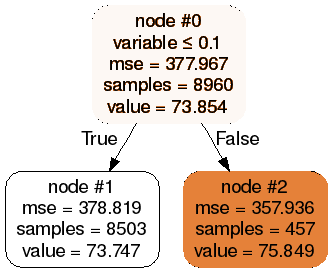

Training tree for long_description|choose (573/2177)
Training tree for long_description|choosing (574/2177)
Training tree for long_description|chosen (575/2177)
Training tree for long_description|cinematic (576/2177)
Training tree for long_description|cities (577/2177)
Training tree for long_description|citizens (578/2177)
Training tree for long_description|city (579/2177)
Training tree for long_description|civilization (580/2177)
Training tree for long_description|claim (581/2177)
Training tree for long_description|class (582/2177)
Training tree for long_description|classes (583/2177)
Training tree for long_description|classic (584/2177)
Training tree for long_description|classics (585/2177)
Training tree for long_description|clear (586/2177)
Training tree for long_description|clever (587/2177)
Training tree for long_description|click (588/2177)
Training tree for long_description|climb (589/2177)
Training tree for long_description|clock (590/2177)
Training tree for long_description|cl

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.001327,0.000487,-378.058311,-377.949079,mse,0.8,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000046,0.000007,5.110782,2.57062
11,0.000569,0.000223,-378.058311,-377.949079,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000076,0.000023,5.110782,2.57062
19,0.000478,0.000225,-378.058311,-377.949079,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000009,0.000023,5.110782,2.57062
1,0.000878,0.000357,-378.058311,-377.949079,mse,0.7,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000312,0.000078,5.110782,2.57062
17,0.000488,0.000207,-378.058311,-377.949079,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000020,0.000002,5.110782,2.57062
16,0.000520,0.000219,-378.058311,-377.949079,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000051,0.000015,5.110782,2.57062
15,0.000550,0.000828,-378.058311,-377.949079,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000113,0.000854,5.110782,2.57062
14,0.000470,0.000205,-378.058311,-377.949079,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000008,0.000001,5.110782,2.57062
13,0.000479,0.000220,-378.058311,-377.949079,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000010,0.000015,5.110782,2.57062
12,0.001585,0.000225,-378.058311,-377.949079,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.001575,0.000028,5.110782,2.57062


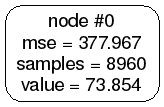

Training tree for long_description|colony (602/2177)
Training tree for long_description|color (603/2177)
Training tree for long_description|colorful (604/2177)
Training tree for long_description|colors (605/2177)
Training tree for long_description|combat (606/2177)
Training tree for long_description|combination (607/2177)
Training tree for long_description|combinations (608/2177)
Training tree for long_description|combine (609/2177)
Training tree for long_description|combined (610/2177)
Training tree for long_description|combines (611/2177)
Training tree for long_description|combining (612/2177)
Training tree for long_description|combo (613/2177)
Training tree for long_description|combos (614/2177)
Training tree for long_description|come (615/2177)
Training tree for long_description|comes (616/2177)
Training tree for long_description|comic (617/2177)
Training tree for long_description|coming (618/2177)
Training tree for long_description|command (619/2177)
Training tree for long_descrip

Training tree for long_description|destiny (754/2177)
Training tree for long_description|destroy (755/2177)
Training tree for long_description|destroyed (756/2177)
Training tree for long_description|destroying (757/2177)
Training tree for long_description|destructible (758/2177)
Training tree for long_description|destruction (759/2177)
Training tree for long_description|detail (760/2177)
Training tree for long_description|detailed (761/2177)
Training tree for long_description|details (762/2177)
Training tree for long_description|detective (763/2177)
Training tree for long_description|determine (764/2177)
Training tree for long_description|devastating (765/2177)
Training tree for long_description|develop (766/2177)
Training tree for long_description|developed (767/2177)
Training tree for long_description|developer (768/2177)
Training tree for long_description|developers (769/2177)
Training tree for long_description|developing (770/2177)
Training tree for long_description|development (77

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.001198,0.000491,-375.454443,-375.292028,mse,0.8,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-376.824206,-374.592829,-381.381219,-372.30251,-368.15546,-378.980745,0.000398,1.527513e-04,5.485445,2.770844
9,0.001017,0.000308,-375.454443,-375.292028,mse,0.45,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-376.824206,-374.592829,-381.381219,-372.30251,-368.15546,-378.980745,0.000307,5.029609e-05,5.485445,2.770844
1,0.000906,0.000426,-375.454443,-375.292028,mse,0.7,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-376.824206,-374.592829,-381.381219,-372.30251,-368.15546,-378.980745,0.000179,8.012409e-05,5.485445,2.770844
16,0.000525,0.000218,-375.454443,-375.292028,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-376.824206,-374.592829,-381.381219,-372.30251,-368.15546,-378.980745,0.000008,8.104673e-07,5.485445,2.770844
15,0.000606,0.000242,-375.454443,-375.292028,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-376.824206,-374.592829,-381.381219,-372.30251,-368.15546,-378.980745,0.000044,1.209503e-05,5.485445,2.770844
14,0.000737,0.000261,-375.454443,-375.292028,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-376.824206,-374.592829,-381.381219,-372.30251,-368.15546,-378.980745,0.000123,1.724872e-05,5.485445,2.770844
12,0.000779,0.000309,-375.454443,-375.292028,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-376.824206,-374.592829,-381.381219,-372.30251,-368.15546,-378.980745,0.000107,8.648977e-05,5.485445,2.770844
11,0.000800,0.000223,-375.454443,-375.292028,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-376.824206,-374.592829,-381.381219,-372.30251,-368.15546,-378.980745,0.000002,1.949921e-06,5.485445,2.770844
10,0.000860,0.000530,-375.454443,-375.292028,mse,0.425,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-376.824206,-374.592829,-381.381219,-372.30251,-368.15546,-378.980745,0.000222,2.512836e-04,5.485445,2.770844
13,0.000790,0.000243,-375.454443,-375.292028,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-376.824206,-374.592829,-381.381219,-372.30251,-368.15546,-378.980745,0.000011,3.311263e-06,5.485445,2.770844


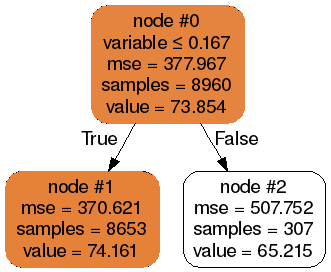

Training tree for long_description|expanded (895/2177)
Training tree for long_description|expansion (896/2177)
Training tree for long_description|expansive (897/2177)
Training tree for long_description|expect (898/2177)
Training tree for long_description|experience (899/2177)
Training tree for long_description|experienced (900/2177)
Training tree for long_description|experiences (901/2177)
Training tree for long_description|experiment (902/2177)
Training tree for long_description|experimental (903/2177)
Training tree for long_description|expert (904/2177)
Training tree for long_description|exploration (905/2177)
Training tree for long_description|explore (906/2177)
Training tree for long_description|exploring (907/2177)
Training tree for long_description|explosions (908/2177)
Training tree for long_description|explosive (909/2177)
Training tree for long_description|extensive (910/2177)
Training tree for long_description|extra (911/2177)
Training tree for long_description|extreme (912/2

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
10,0.000962,0.000280,-377.721210,-377.276787,mse,0.425,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.611900,-376.753411,-383.120738,-374.476885,-371.428886,-380.600063,0.000454,0.000081,4.814425,2.527023
11,0.000667,0.000278,-377.721210,-377.276787,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.611900,-376.753411,-383.120738,-374.476885,-371.428886,-380.600063,0.000026,0.000083,4.814425,2.527023
12,0.000757,0.000253,-377.721210,-377.276787,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.611900,-376.753411,-383.120738,-374.476885,-371.428886,-380.600063,0.000108,0.000021,4.814425,2.527023
13,0.000668,0.000224,-377.721210,-377.276787,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.611900,-376.753411,-383.120738,-374.476885,-371.428886,-380.600063,0.000017,0.000008,4.814425,2.527023
14,0.000633,0.000213,-377.721210,-377.276787,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.611900,-376.753411,-383.120738,-374.476885,-371.428886,-380.600063,0.000010,0.000001,4.814425,2.527023
15,0.001214,0.000242,-377.721210,-377.276787,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.611900,-376.753411,-383.120738,-374.476885,-371.428886,-380.600063,0.000769,0.000026,4.814425,2.527023
19,0.000696,0.000235,-377.990208,-376.941232,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",7,-379.470667,-375.908980,-383.120738,-374.476885,-371.377004,-380.437830,0.000048,0.000015,4.907205,2.540653
18,0.000974,0.000237,-378.007498,-376.995310,mse,0.175,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-379.470667,-375.908980,-383.120738,-374.476885,-371.428886,-380.600063,0.000381,0.000012,4.883910,2.615137
16,0.000840,0.000247,-378.007498,-376.995310,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-379.470667,-375.908980,-383.120738,-374.476885,-371.428886,-380.600063,0.000205,0.000007,4.883910,2.615137
17,0.000713,0.000240,-378.007498,-376.995310,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-379.470667,-375.908980,-383.120738,-374.476885,-371.428886,-380.600063,0.000081,0.000025,4.883910,2.615137


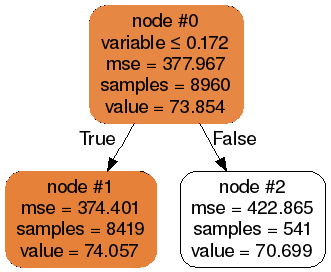

Training tree for long_description|gamepad (1027/2177)
Training tree for long_description|gameplay (1028/2177)
Training tree for long_description|gamer (1029/2177)
Training tree for long_description|gamers (1030/2177)
Training tree for long_description|games (1031/2177)
Training tree for long_description|gaming (1032/2177)
Training tree for long_description|gather (1033/2177)
Training tree for long_description|gathering (1034/2177)
Training tree for long_description|gear (1035/2177)
Training tree for long_description|general (1036/2177)
Training tree for long_description|generated (1037/2177)
Training tree for long_description|generation (1038/2177)
Training tree for long_description|genre (1039/2177)
Training tree for long_description|german (1040/2177)
Training tree for long_description|gets (1041/2177)
Training tree for long_description|getting (1042/2177)
Training tree for long_description|ghost (1043/2177)
Training tree for long_description|giant (1044/2177)
Training tree for long

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
37,0.000524,0.000211,-377.997411,-377.535381,friedman_mse,0.375,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",1,-378.147846,-377.409293,-384.249687,-374.443082,-371.592556,-380.753768,0.000023,0.000003,5.168203,2.577869
36,0.000570,0.000462,-377.997411,-377.535381,friedman_mse,0.4,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",1,-378.147846,-377.409293,-384.249687,-374.443082,-371.592556,-380.753768,0.000073,0.000345,5.168203,2.577869
27,0.002710,0.000238,-377.997411,-377.535381,friedman_mse,0.65,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",1,-378.147846,-377.409293,-384.249687,-374.443082,-371.592556,-380.753768,0.003069,0.000026,5.168203,2.577869
26,0.000552,0.000222,-377.997411,-377.535381,friedman_mse,0.7,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",1,-378.147846,-377.409293,-384.249687,-374.443082,-371.592556,-380.753768,0.000054,0.000014,5.168203,2.577869
25,0.000625,0.000226,-377.997411,-377.535381,friedman_mse,0.8,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",1,-378.147846,-377.409293,-384.249687,-374.443082,-371.592556,-380.753768,0.000102,0.000007,5.168203,2.577869
24,0.000804,0.000325,-377.997411,-377.535381,mse,0.001,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.147846,-377.409293,-384.249687,-374.443082,-371.592556,-380.753768,0.000257,0.000098,5.168203,2.577869
23,0.000580,0.000225,-377.997411,-377.535381,mse,0.005,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.147846,-377.409293,-384.249687,-374.443082,-371.592556,-380.753768,0.000014,0.000004,5.168203,2.577869
22,0.000572,0.000219,-377.997411,-377.535381,mse,0.01,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.147846,-377.409293,-384.249687,-374.443082,-371.592556,-380.753768,0.000011,0.000002,5.168203,2.577869
30,0.000557,0.000226,-377.997411,-377.535381,friedman_mse,0.575,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",1,-378.147846,-377.409293,-384.249687,-374.443082,-371.592556,-380.753768,0.000031,0.000007,5.168203,2.577869
31,0.000678,0.000307,-377.997411,-377.535381,friedman_mse,0.55,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",1,-378.147846,-377.409293,-384.249687,-374.443082,-371.592556,-380.753768,0.000123,0.000117,5.168203,2.577869


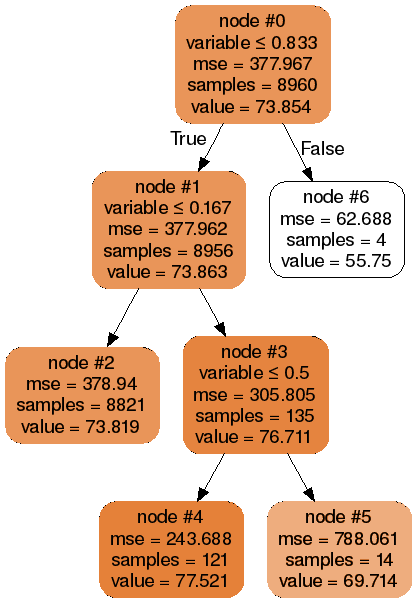

Training tree for long_description|gone (1061/2177)
Training tree for long_description|good (1062/2177)
Training tree for long_description|goods (1063/2177)
Training tree for long_description|gorgeous (1064/2177)
Training tree for long_description|got (1065/2177)
Training tree for long_description|government (1066/2177)
Training tree for long_description|grab (1067/2177)
Training tree for long_description|grand (1068/2177)
Training tree for long_description|graphic (1069/2177)
Training tree for long_description|graphics (1070/2177)
Training tree for long_description|gravity (1071/2177)
Training tree for long_description|great (1072/2177)
Training tree for long_description|greater (1073/2177)
Training tree for long_description|greatest (1074/2177)
Training tree for long_description|green (1075/2177)
Training tree for long_description|grenades (1076/2177)
Training tree for long_description|ground (1077/2177)
Training tree for long_description|group (1078/2177)
Training tree for long_desc

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
37,0.002905,0.001012,-377.852703,-377.622171,friedman_mse,0.375,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",1,-378.129782,-377.442086,-384.053451,-374.559089,-371.372707,-380.865338,0.001491,0.000551,5.180455,2.577663
35,0.000601,0.000668,-377.852703,-377.622171,friedman_mse,0.425,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",1,-378.129782,-377.442086,-384.053451,-374.559089,-371.372707,-380.865338,0.000077,0.000601,5.180455,2.577663
29,0.000726,0.000277,-377.852703,-377.622171,friedman_mse,0.6,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",1,-378.129782,-377.442086,-384.053451,-374.559089,-371.372707,-380.865338,0.000172,0.000043,5.180455,2.577663
28,0.000583,0.000235,-377.852703,-377.622171,friedman_mse,0.625,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",1,-378.129782,-377.442086,-384.053451,-374.559089,-371.372707,-380.865338,0.000020,0.000005,5.180455,2.577663
27,0.000835,0.000268,-377.852703,-377.622171,friedman_mse,0.65,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",1,-378.129782,-377.442086,-384.053451,-374.559089,-371.372707,-380.865338,0.000352,0.000049,5.180455,2.577663
26,0.002535,0.000264,-377.852703,-377.622171,friedman_mse,0.7,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",1,-378.129782,-377.442086,-384.053451,-374.559089,-371.372707,-380.865338,0.001858,0.000012,5.180455,2.577663
25,0.001090,0.000702,-377.852703,-377.622171,friedman_mse,0.8,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",1,-378.129782,-377.442086,-384.053451,-374.559089,-371.372707,-380.865338,0.000581,0.000572,5.180455,2.577663
24,0.000712,0.000251,-377.852703,-377.622171,mse,0.001,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.129782,-377.442086,-384.053451,-374.559089,-371.372707,-380.865338,0.000220,0.000033,5.180455,2.577663
23,0.000659,0.000245,-377.852703,-377.622171,mse,0.005,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.129782,-377.442086,-384.053451,-374.559089,-371.372707,-380.865338,0.000124,0.000026,5.180455,2.577663
22,0.000595,0.000229,-377.852703,-377.622171,mse,0.01,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.129782,-377.442086,-384.053451,-374.559089,-371.372707,-380.865338,0.000022,0.000006,5.180455,2.577663


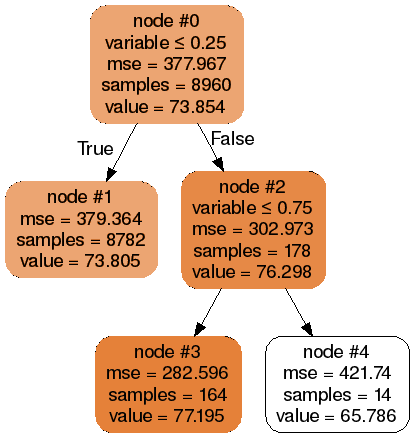

Training tree for long_description|imagine (1155/2177)
Training tree for long_description|immediately (1156/2177)
Training tree for long_description|immerse (1157/2177)
Training tree for long_description|immersion (1158/2177)
Training tree for long_description|immersive (1159/2177)
Training tree for long_description|impact (1160/2177)
Training tree for long_description|important (1161/2177)
Training tree for long_description|impossible (1162/2177)
Training tree for long_description|impressive (1163/2177)
Training tree for long_description|improve (1164/2177)
Training tree for long_description|improved (1165/2177)
Training tree for long_description|improvements (1166/2177)
Training tree for long_description|include (1167/2177)
Training tree for long_description|included (1168/2177)
Training tree for long_description|includes (1169/2177)
Training tree for long_description|including (1170/2177)
Training tree for long_description|increase (1171/2177)
Training tree for long_description|incr

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
23,0.000579,0.000220,-377.734719,-377.375187,mse,0.005,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.061567,-377.217886,-383.669859,-374.391296,-371.470634,-380.516378,0.000020,0.000004,4.985534,2.503027
22,0.000693,0.000333,-377.734719,-377.375187,mse,0.01,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.061567,-377.217886,-383.669859,-374.391296,-371.470634,-380.516378,0.000126,0.000143,4.985534,2.503027
37,0.000554,0.000218,-377.764272,-377.373691,friedman_mse,0.375,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",3,-378.061567,-377.217886,-383.758507,-374.386808,-371.470634,-380.516378,0.000019,0.000003,5.020767,2.504810
31,0.000909,0.000232,-377.764272,-377.373691,friedman_mse,0.55,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",3,-378.061567,-377.217886,-383.758507,-374.386808,-371.470634,-380.516378,0.000468,0.000013,5.020767,2.504810
29,0.000620,0.000231,-377.764272,-377.373691,friedman_mse,0.6,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",3,-378.061567,-377.217886,-383.758507,-374.386808,-371.470634,-380.516378,0.000068,0.000005,5.020767,2.504810
28,0.000594,0.000233,-377.764272,-377.373691,friedman_mse,0.625,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",3,-378.061567,-377.217886,-383.758507,-374.386808,-371.470634,-380.516378,0.000044,0.000009,5.020767,2.504810
27,0.000746,0.000283,-377.764272,-377.373691,friedman_mse,0.65,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",3,-378.061567,-377.217886,-383.758507,-374.386808,-371.470634,-380.516378,0.000198,0.000027,5.020767,2.504810
26,0.000642,0.000237,-377.764272,-377.373691,friedman_mse,0.7,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",3,-378.061567,-377.217886,-383.758507,-374.386808,-371.470634,-380.516378,0.000064,0.000023,5.020767,2.504810
25,0.001294,0.000235,-377.764272,-377.373691,friedman_mse,0.8,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",3,-378.061567,-377.217886,-383.758507,-374.386808,-371.470634,-380.516378,0.001013,0.000017,5.020767,2.504810
24,0.000565,0.000217,-377.764272,-377.373691,mse,0.001,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",3,-378.061567,-377.217886,-383.758507,-374.386808,-371.470634,-380.516378,0.000018,0.000003,5.020767,2.504810


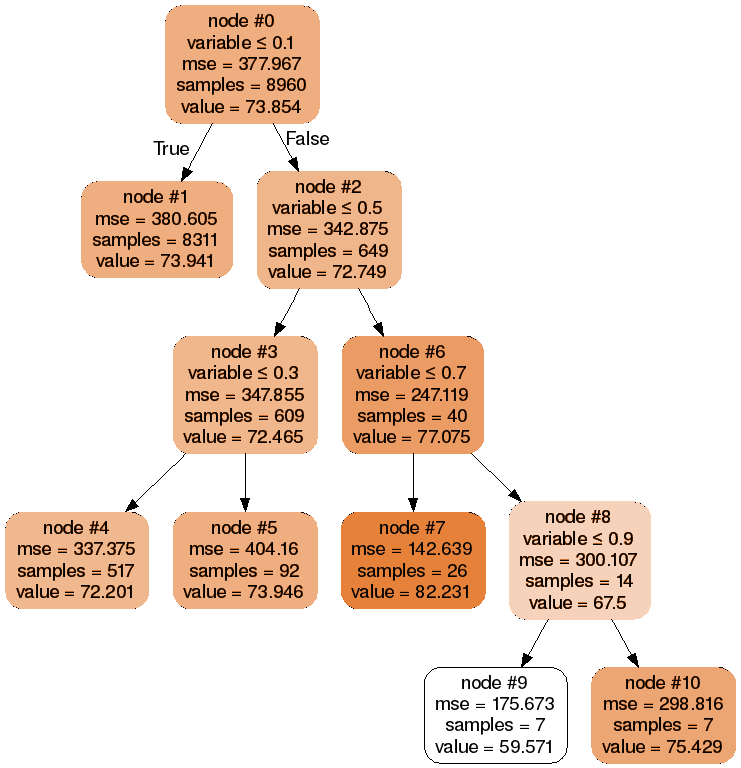

Training tree for long_description|lands (1243/2177)
Training tree for long_description|landscape (1244/2177)
Training tree for long_description|landscapes (1245/2177)
Training tree for long_description|language (1246/2177)
Training tree for long_description|large (1247/2177)
Training tree for long_description|larger (1248/2177)
Training tree for long_description|laser (1249/2177)
Training tree for long_description|lasers (1250/2177)
Training tree for long_description|late (1251/2177)
Training tree for long_description|later (1252/2177)
Training tree for long_description|latest (1253/2177)
Training tree for long_description|launch (1254/2177)
Training tree for long_description|lead (1255/2177)
Training tree for long_description|leader (1256/2177)
Training tree for long_description|leaderboard (1257/2177)
Training tree for long_description|leaderboards (1258/2177)
Training tree for long_description|leading (1259/2177)
Training tree for long_description|leads (1260/2177)
Training tree fo

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.001187,0.000533,-378.058311,-377.949079,mse,0.8,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000145,9.073622e-05,5.110782,2.57062
8,0.000463,0.000204,-378.058311,-377.949079,mse,0.475,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000003,8.485379e-07,5.110782,2.57062
1,0.000552,0.000232,-378.058311,-377.949079,mse,0.7,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000005,5.947204e-07,5.110782,2.57062
14,0.000471,0.000206,-378.058311,-377.949079,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000006,1.910657e-06,5.110782,2.57062
13,0.000504,0.000237,-378.058311,-377.949079,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000026,2.458552e-05,5.110782,2.57062
11,0.000472,0.000207,-378.058311,-377.949079,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000003,1.276523e-06,5.110782,2.57062
10,0.000474,0.000207,-378.058311,-377.949079,mse,0.425,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000004,1.189441e-06,5.110782,2.57062
9,0.000481,0.000213,-378.058311,-377.949079,mse,0.45,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000008,3.164976e-06,5.110782,2.57062
12,0.000471,0.000208,-378.058311,-377.949079,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000004,3.040811e-06,5.110782,2.57062
7,0.000516,0.000211,-378.058311,-377.949079,mse,0.5,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000064,8.461527e-06,5.110782,2.57062


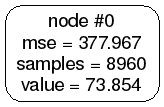

Training tree for long_description|lethal (1271/2177)
Training tree for long_description|lets (1272/2177)
Training tree for long_description|level (1273/2177)
Training tree for long_description|levels (1274/2177)
Training tree for long_description|lies (1275/2177)
Training tree for long_description|life (1276/2177)
Training tree for long_description|light (1277/2177)
Training tree for long_description|lighting (1278/2177)
Training tree for long_description|lightning (1279/2177)
Training tree for long_description|lights (1280/2177)
Training tree for long_description|like (1281/2177)
Training tree for long_description|limit (1282/2177)
Training tree for long_description|limited (1283/2177)
Training tree for long_description|limits (1284/2177)
Training tree for long_description|line (1285/2177)
Training tree for long_description|linear (1286/2177)
Training tree for long_description|lines (1287/2177)
Training tree for long_description|linux (1288/2177)
Training tree for long_description|li

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.001268,0.000523,-378.058311,-377.949079,mse,0.8,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000240,0.000055,5.110782,2.57062
11,0.000504,0.000221,-378.058311,-377.949079,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000038,0.000011,5.110782,2.57062
1,0.000646,0.000264,-378.058311,-377.949079,mse,0.7,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000060,0.000031,5.110782,2.57062
19,0.000517,0.000215,-378.058311,-377.949079,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000068,0.000012,5.110782,2.57062
18,0.000569,0.000207,-378.058311,-377.949079,mse,0.175,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000159,0.000004,5.110782,2.57062
17,0.000512,0.000212,-378.058311,-377.949079,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000053,0.000009,5.110782,2.57062
16,0.000446,0.000204,-378.058311,-377.949079,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000003,0.000003,5.110782,2.57062
15,0.000465,0.000206,-378.058311,-377.949079,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000013,0.000002,5.110782,2.57062
14,0.000496,0.000218,-378.058311,-377.949079,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000051,0.000019,5.110782,2.57062
12,0.000514,0.000228,-378.058311,-377.949079,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000038,0.000024,5.110782,2.57062


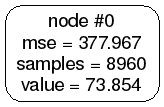

Training tree for long_description|meaning (1353/2177)
Training tree for long_description|means (1354/2177)
Training tree for long_description|mechanic (1355/2177)
Training tree for long_description|mechanics (1356/2177)
Training tree for long_description|medieval (1357/2177)
Training tree for long_description|meet (1358/2177)
Training tree for long_description|meets (1359/2177)
Training tree for long_description|melee (1360/2177)
Training tree for long_description|member (1361/2177)
Training tree for long_description|members (1362/2177)
Training tree for long_description|memories (1363/2177)
Training tree for long_description|memory (1364/2177)
Training tree for long_description|men (1365/2177)
Training tree for long_description|menu (1366/2177)
Training tree for long_description|metal (1367/2177)
Training tree for long_description|middle (1368/2177)
Training tree for long_description|mighty (1369/2177)
Training tree for long_description|military (1370/2177)
Training tree for long_des

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.002033,0.001513,-378.058311,-377.949079,mse,0.8,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.001246,0.001418,5.110782,2.57062
10,0.000523,0.000209,-378.058311,-377.949079,mse,0.425,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000047,0.000005,5.110782,2.57062
1,0.000751,0.000324,-378.058311,-377.949079,mse,0.7,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000250,0.000123,5.110782,2.57062
17,0.000482,0.000209,-378.058311,-377.949079,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000012,0.000003,5.110782,2.57062
16,0.000521,0.000228,-378.058311,-377.949079,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000021,0.000008,5.110782,2.57062
15,0.000488,0.000211,-378.058311,-377.949079,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000009,0.000003,5.110782,2.57062
14,0.000588,0.000243,-378.058311,-377.949079,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000075,0.000024,5.110782,2.57062
13,0.000522,0.000222,-378.058311,-377.949079,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000003,0.000005,5.110782,2.57062
12,0.000546,0.000246,-378.058311,-377.949079,mse,0.375,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000062,0.000006,5.110782,2.57062
11,0.000488,0.000219,-378.058311,-377.949079,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000031,0.000021,5.110782,2.57062


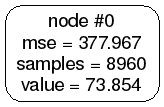

Training tree for long_description|obstacles (1450/2177)
Training tree for long_description|obtain (1451/2177)
Training tree for long_description|ocean (1452/2177)
Training tree for long_description|oculus (1453/2177)
Training tree for long_description|offer (1454/2177)
Training tree for long_description|offering (1455/2177)
Training tree for long_description|offers (1456/2177)
Training tree for long_description|official (1457/2177)
Training tree for long_description|offline (1458/2177)
Training tree for long_description|old (1459/2177)
Training tree for long_description|ones (1460/2177)
Training tree for long_description|online (1461/2177)
Training tree for long_description|op (1462/2177)
Training tree for long_description|open (1463/2177)
Training tree for long_description|operation (1464/2177)
Training tree for long_description|operations (1465/2177)
Training tree for long_description|opponent (1466/2177)


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
19,0.000492,0.000216,-377.869442,-377.740420,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.153311,-377.577270,-383.862444,-374.733160,-371.590469,-380.910831,0.000010,0.000012,5.013893,2.524661
20,0.000502,0.000213,-377.920598,-377.705167,mse,0.1,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",2,-378.153311,-377.577270,-384.015895,-374.627400,-371.590469,-380.910831,0.000019,0.000005,5.075186,2.566794
21,0.000579,0.000230,-378.037123,-377.658587,mse,0.05,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",3,-378.418699,-377.520631,-384.100042,-374.544298,-371.590469,-380.910831,0.000030,0.000019,5.113993,2.600956
18,0.000531,0.000228,-378.046870,-377.855426,mse,0.175,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-378.419685,-377.751012,-384.128295,-374.904435,-371.590469,-380.910831,0.000076,0.000015,5.125188,2.453212
17,0.000595,0.000227,-378.046870,-377.855426,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-378.419685,-377.751012,-384.128295,-374.904435,-371.590469,-380.910831,0.000151,0.000025,5.125188,2.453212
16,0.000494,0.000213,-378.046870,-377.855426,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-378.419685,-377.751012,-384.128295,-374.904435,-371.590469,-380.910831,0.000017,0.000002,5.125188,2.453212
15,0.000493,0.000212,-378.046870,-377.855426,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-378.419685,-377.751012,-384.128295,-374.904435,-371.590469,-380.910831,0.000018,0.000003,5.125188,2.453212
11,0.000479,0.000209,-378.058311,-377.949079,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.191790,0.000005,0.000001,5.110782,2.570620
14,0.000530,0.000228,-378.058311,-377.949079,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.191790,0.000041,0.000013,5.110782,2.570620
13,0.000595,0.000238,-378.058311,-377.949079,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.191790,0.000117,0.000026,5.110782,2.570620


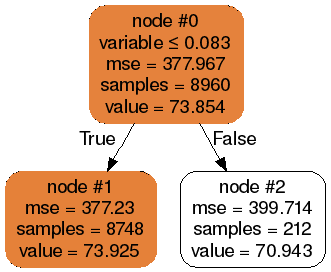

Training tree for long_description|opponents (1467/2177)
Training tree for long_description|opportunities (1468/2177)
Training tree for long_description|opportunity (1469/2177)
Training tree for long_description|option (1470/2177)
Training tree for long_description|optional (1471/2177)
Training tree for long_description|options (1472/2177)
Training tree for long_description|order (1473/2177)
Training tree for long_description|orders (1474/2177)
Training tree for long_description|original (1475/2177)
Training tree for long_description|originally (1476/2177)
Training tree for long_description|outcome (1477/2177)
Training tree for long_description|outside (1478/2177)
Training tree for long_description|overcome (1479/2177)
Training tree for long_description|pace (1480/2177)
Training tree for long_description|paced (1481/2177)
Training tree for long_description|pack (1482/2177)
Training tree for long_description|packed (1483/2177)
Training tree for long_description|packs (1484/2177)
Trainin

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.001118,0.000540,-378.058311,-377.949079,mse,0.8,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.191790,0.000068,0.000056,5.110782,2.570620
38,0.000514,0.000209,-378.324645,-377.262023,friedman_mse,0.35,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",2,-378.372430,-377.725670,-384.985934,-373.732836,-371.613324,-380.327562,0.000019,0.000004,5.459298,2.712173
27,0.000574,0.000232,-378.324645,-377.262023,friedman_mse,0.65,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",2,-378.372430,-377.725670,-384.985934,-373.732836,-371.613324,-380.327562,0.000005,0.000004,5.459298,2.712173
28,0.000544,0.000217,-378.324645,-377.262023,friedman_mse,0.625,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",2,-378.372430,-377.725670,-384.985934,-373.732836,-371.613324,-380.327562,0.000024,0.000004,5.459298,2.712173
29,0.000570,0.000226,-378.324645,-377.262023,friedman_mse,0.6,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",2,-378.372430,-377.725670,-384.985934,-373.732836,-371.613324,-380.327562,0.000026,0.000013,5.459298,2.712173
30,0.004890,0.000247,-378.324645,-377.262023,friedman_mse,0.575,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",2,-378.372430,-377.725670,-384.985934,-373.732836,-371.613324,-380.327562,0.005945,0.000019,5.459298,2.712173
31,0.000528,0.000211,-378.324645,-377.262023,friedman_mse,0.55,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",2,-378.372430,-377.725670,-384.985934,-373.732836,-371.613324,-380.327562,0.000022,0.000003,5.459298,2.712173
32,0.000563,0.000278,-378.324645,-377.262023,friedman_mse,0.5,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",2,-378.372430,-377.725670,-384.985934,-373.732836,-371.613324,-380.327562,0.000030,0.000072,5.459298,2.712173
33,0.000635,0.000232,-378.324645,-377.262023,friedman_mse,0.475,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",2,-378.372430,-377.725670,-384.985934,-373.732836,-371.613324,-380.327562,0.000086,0.000007,5.459298,2.712173
34,0.000592,0.000232,-378.324645,-377.262023,friedman_mse,0.45,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",2,-378.372430,-377.725670,-384.985934,-373.732836,-371.613324,-380.327562,0.000033,0.000005,5.459298,2.712173


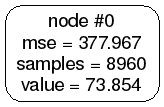

Training tree for long_description|procedural (1578/2177)
Training tree for long_description|procedurally (1579/2177)
Training tree for long_description|process (1580/2177)
Training tree for long_description|product (1581/2177)
Training tree for long_description|production (1582/2177)
Training tree for long_description|professional (1583/2177)
Training tree for long_description|progress (1584/2177)
Training tree for long_description|progression (1585/2177)
Training tree for long_description|project (1586/2177)
Training tree for long_description|protagonist (1587/2177)
Training tree for long_description|protect (1588/2177)
Training tree for long_description|prove (1589/2177)
Training tree for long_description|provide (1590/2177)
Training tree for long_description|provides (1591/2177)
Training tree for long_description|providing (1592/2177)
Training tree for long_description|pull (1593/2177)
Training tree for long_description|purchase (1594/2177)
Training tree for long_description|pure (

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
17,0.000513,0.000208,-377.473659,-377.253914,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.713675,-377.111966,-383.403153,-374.294248,-371.302082,-380.355528,0.000001,6.743496e-07,4.943019,2.476542
19,0.000532,0.000212,-377.473659,-377.253914,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.713675,-377.111966,-383.403153,-374.294248,-371.302082,-380.355528,0.000006,5.129541e-06,4.943019,2.476542
18,0.000745,0.000616,-377.473659,-377.253914,mse,0.175,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-377.713675,-377.111966,-383.403153,-374.294248,-371.302082,-380.355528,0.000288,5.713431e-04,4.943019,2.476542
20,0.000554,0.000214,-377.545217,-377.219271,mse,0.1,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-377.713675,-377.111966,-383.617803,-374.190320,-371.302082,-380.355528,0.000018,1.808772e-06,5.029143,2.518079
21,0.000585,0.000221,-377.545217,-377.219271,mse,0.05,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-377.713675,-377.111966,-383.617803,-374.190320,-371.302082,-380.355528,0.000075,1.507431e-05,5.029143,2.518079
22,0.000563,0.000263,-377.557011,-377.203421,mse,0.01,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",6,-377.713675,-377.111966,-383.617803,-374.190320,-371.337472,-380.307976,0.000010,5.723779e-05,5.014508,2.498360
35,0.000856,0.000246,-377.603737,-377.200448,friedman_mse,0.425,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",7,-377.853837,-377.103048,-383.617803,-374.190320,-371.337472,-380.307976,0.000198,1.363093e-05,5.016403,2.498472
26,0.000545,0.000224,-377.603737,-377.200448,friedman_mse,0.7,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",7,-377.853837,-377.103048,-383.617803,-374.190320,-371.337472,-380.307976,0.000001,8.990625e-06,5.016403,2.498472
23,0.000572,0.000223,-377.603737,-377.200448,mse,0.005,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",7,-377.853837,-377.103048,-383.617803,-374.190320,-371.337472,-380.307976,0.000009,7.315821e-06,5.016403,2.498472
38,0.000662,0.000242,-377.603737,-377.200448,friedman_mse,0.35,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",7,-377.853837,-377.103048,-383.617803,-374.190320,-371.337472,-380.307976,0.000062,5.857317e-06,5.016403,2.498472


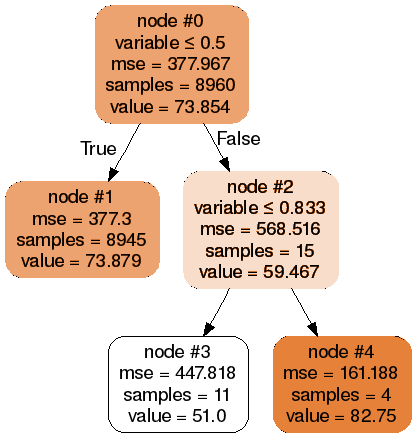

Training tree for long_description|resource (1659/2177)
Training tree for long_description|resources (1660/2177)
Training tree for long_description|rest (1661/2177)
Training tree for long_description|restore (1662/2177)
Training tree for long_description|result (1663/2177)
Training tree for long_description|results (1664/2177)
Training tree for long_description|retro (1665/2177)
Training tree for long_description|return (1666/2177)
Training tree for long_description|returns (1667/2177)
Training tree for long_description|reveal (1668/2177)
Training tree for long_description|revenge (1669/2177)
Training tree for long_description|reward (1670/2177)
Training tree for long_description|rewarding (1671/2177)
Training tree for long_description|rewards (1672/2177)
Training tree for long_description|rich (1673/2177)
Training tree for long_description|ride (1674/2177)
Training tree for long_description|rift (1675/2177)
Training tree for long_description|right (1676/2177)
Training tree for long_de

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.001118,0.000495,-378.058311,-377.949079,mse,0.8,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.191790,0.000062,0.000036,5.110782,2.570620
4,0.000475,0.000208,-378.058311,-377.949079,mse,0.6,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.191790,0.000030,0.000009,5.110782,2.570620
6,0.000448,0.000203,-378.058311,-377.949079,mse,0.55,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.191790,0.000002,0.000004,5.110782,2.570620
5,0.000532,0.000215,-378.058311,-377.949079,mse,0.575,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.191790,0.000047,0.000014,5.110782,2.570620
1,0.000732,0.000311,-378.058311,-377.949079,mse,0.7,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.191790,0.000219,0.000106,5.110782,2.570620
3,0.000576,0.000215,-378.058311,-377.949079,mse,0.625,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.191790,0.000186,0.000010,5.110782,2.570620
2,0.000574,0.000242,-378.058311,-377.949079,mse,0.65,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.191790,0.000034,0.000016,5.110782,2.570620
13,0.000476,0.000207,-378.290162,-377.775651,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-378.419685,-377.751012,-384.128295,-374.904435,-372.320509,-380.671505,0.000024,0.000003,4.821244,2.354461
17,0.000481,0.000205,-378.290162,-377.775651,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-378.419685,-377.751012,-384.128295,-374.904435,-372.320509,-380.671505,0.000024,0.000003,4.821244,2.354461
16,0.000540,0.000225,-378.290162,-377.775651,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-378.419685,-377.751012,-384.128295,-374.904435,-372.320509,-380.671505,0.000061,0.000015,4.821244,2.354461


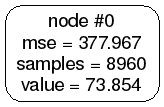

Training tree for long_description|science (1723/2177)
Training tree for long_description|score (1724/2177)
Training tree for long_description|scores (1725/2177)
Training tree for long_description|screen (1726/2177)
Training tree for long_description|scrolling (1727/2177)
Training tree for long_description|sea (1728/2177)
Training tree for long_description|seamlessly (1729/2177)
Training tree for long_description|search (1730/2177)
Training tree for long_description|searching (1731/2177)
Training tree for long_description|season (1732/2177)
Training tree for long_description|second (1733/2177)
Training tree for long_description|seconds (1734/2177)
Training tree for long_description|secret (1735/2177)
Training tree for long_description|secrets (1736/2177)
Training tree for long_description|security (1737/2177)
Training tree for long_description|seek (1738/2177)
Training tree for long_description|seen (1739/2177)
Training tree for long_description|select (1740/2177)
Training tree for lon

Training tree for long_description|straight (1875/2177)
Training tree for long_description|strange (1876/2177)
Training tree for long_description|strategic (1877/2177)
Training tree for long_description|strategies (1878/2177)
Training tree for long_description|strategy (1879/2177)
Training tree for long_description|street (1880/2177)
Training tree for long_description|streets (1881/2177)
Training tree for long_description|strength (1882/2177)
Training tree for long_description|strengths (1883/2177)
Training tree for long_description|strike (1884/2177)
Training tree for long_description|strong (1885/2177)
Training tree for long_description|stronger (1886/2177)
Training tree for long_description|structures (1887/2177)
Training tree for long_description|struggle (1888/2177)
Training tree for long_description|studio (1889/2177)
Training tree for long_description|studios (1890/2177)
Training tree for long_description|stuff (1891/2177)
Training tree for long_description|stunning (1892/2177)


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.001222,0.000963,-378.058311,-377.949079,mse,0.8,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000237,9.872455e-05,5.110782,2.57062
11,0.000502,0.000224,-378.058311,-377.949079,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000034,9.824466e-06,5.110782,2.57062
21,0.000455,0.000203,-378.058311,-377.949079,mse,0.05,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000005,5.947204e-07,5.110782,2.57062
20,0.000484,0.000204,-378.058311,-377.949079,mse,0.1,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000042,1.083865e-06,5.110782,2.57062
19,0.000469,0.000205,-378.058311,-377.949079,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000009,1.655632e-06,5.110782,2.57062
17,0.000515,0.000206,-378.058311,-377.949079,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000078,4.561216e-06,5.110782,2.57062
16,0.000470,0.000208,-378.058311,-377.949079,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000007,1.106929e-06,5.110782,2.57062
15,0.000488,0.000225,-378.058311,-377.949079,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000019,1.678364e-05,5.110782,2.57062
14,0.000517,0.000214,-378.058311,-377.949079,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000044,6.072267e-06,5.110782,2.57062
13,0.000454,0.000204,-378.058311,-377.949079,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000003,1.593426e-06,5.110782,2.57062


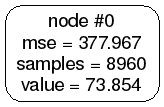

Training tree for long_description|tank (1934/2177)
Training tree for long_description|tanks (1935/2177)
Training tree for long_description|target (1936/2177)
Training tree for long_description|targets (1937/2177)
Training tree for long_description|task (1938/2177)
Training tree for long_description|tasks (1939/2177)
Training tree for long_description|team (1940/2177)
Training tree for long_description|teams (1941/2177)
Training tree for long_description|tech (1942/2177)
Training tree for long_description|techniques (1943/2177)
Training tree for long_description|technologies (1944/2177)
Training tree for long_description|technology (1945/2177)
Training tree for long_description|tell (1946/2177)
Training tree for long_description|tells (1947/2177)
Training tree for long_description|terrain (1948/2177)
Training tree for long_description|terrible (1949/2177)
Training tree for long_description|terrifying (1950/2177)
Training tree for long_description|territory (1951/2177)
Training tree for

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
21,0.000766,0.000215,-377.888871,-377.763165,mse,0.05,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.185699,-377.564904,-384.025919,-374.651749,-371.452839,-381.072842,0.000359,0.000008,5.137085,2.625147
20,0.000507,0.000218,-377.949439,-377.810021,mse,0.1,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",2,-378.273333,-377.619325,-384.119971,-374.737895,-371.452839,-381.072842,0.000013,0.000010,5.176261,2.589744
23,0.000561,0.000223,-377.978449,-377.698981,mse,0.005,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",3,-378.388824,-377.517647,-384.162627,-374.586203,-371.381688,-380.993092,0.000033,0.000007,5.225715,2.618742
22,0.000651,0.000440,-377.978449,-377.698981,mse,0.01,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",3,-378.388824,-377.517647,-384.162627,-374.586203,-371.381688,-380.993092,0.000113,0.000278,5.225715,2.618742
37,0.000622,0.000275,-377.983871,-377.697690,friedman_mse,0.375,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",5,-378.388824,-377.517647,-384.162627,-374.586203,-371.397959,-380.989220,0.000108,0.000077,5.218871,2.617119
32,0.000523,0.000214,-377.983871,-377.697690,friedman_mse,0.5,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",5,-378.388824,-377.517647,-384.162627,-374.586203,-371.397959,-380.989220,0.000029,0.000003,5.218871,2.617119
30,0.002220,0.000523,-377.983871,-377.697690,friedman_mse,0.575,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",5,-378.388824,-377.517647,-384.162627,-374.586203,-371.397959,-380.989220,0.002247,0.000379,5.218871,2.617119
29,0.000522,0.000210,-377.983871,-377.697690,friedman_mse,0.6,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",5,-378.388824,-377.517647,-384.162627,-374.586203,-371.397959,-380.989220,0.000021,0.000003,5.218871,2.617119
28,0.000551,0.000220,-377.983871,-377.697690,friedman_mse,0.625,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",5,-378.388824,-377.517647,-384.162627,-374.586203,-371.397959,-380.989220,0.000032,0.000008,5.218871,2.617119
27,0.000524,0.000215,-377.983871,-377.697690,friedman_mse,0.65,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",5,-378.388824,-377.517647,-384.162627,-374.586203,-371.397959,-380.989220,0.000022,0.000006,5.218871,2.617119


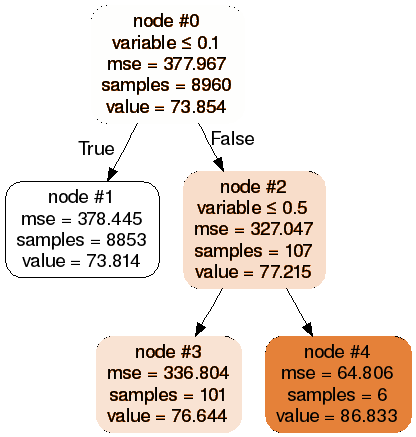

Training tree for long_description|test (1953/2177)
Training tree for long_description|text (1954/2177)
Training tree for long_description|thanks (1955/2177)
Training tree for long_description|theme (1956/2177)
Training tree for long_description|themed (1957/2177)
Training tree for long_description|themes (1958/2177)
Training tree for long_description|thing (1959/2177)
Training tree for long_description|things (1960/2177)
Training tree for long_description|think (1961/2177)
Training tree for long_description|thinking (1962/2177)
Training tree for long_description|thought (1963/2177)
Training tree for long_description|thousands (1964/2177)
Training tree for long_description|threat (1965/2177)
Training tree for long_description|thrill (1966/2177)
Training tree for long_description|thrilling (1967/2177)
Training tree for long_description|throw (1968/2177)
Training tree for long_description|time (1969/2177)
Training tree for long_description|times (1970/2177)
Training tree for long_descrip

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
18,0.000521,0.000211,-377.864763,-377.592701,mse,0.175,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.456772,-377.280273,-383.833349,-374.579497,-371.301970,-380.918333,5.947204e-07,0.000001,5.132873,2.597232
20,0.000548,0.000219,-377.864763,-377.592701,mse,0.1,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.456772,-377.280273,-383.833349,-374.579497,-371.301970,-380.918333,9.418791e-06,0.000003,5.132873,2.597232
19,0.000609,0.000238,-377.864763,-377.592701,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.456772,-377.280273,-383.833349,-374.579497,-371.301970,-380.918333,7.554321e-05,0.000015,5.132873,2.597232
17,0.000531,0.000213,-377.864763,-377.592701,mse,0.2,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.456772,-377.280273,-383.833349,-374.579497,-371.301970,-380.918333,4.866699e-06,0.000002,5.132873,2.597232
16,0.000971,0.000230,-377.864763,-377.592701,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.456772,-377.280273,-383.833349,-374.579497,-371.301970,-380.918333,5.414639e-04,0.000011,5.132873,2.597232
15,0.000563,0.000209,-377.864763,-377.592701,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.456772,-377.280273,-383.833349,-374.579497,-371.301970,-380.918333,5.639337e-05,0.000003,5.132873,2.597232
21,0.000636,0.000224,-377.867313,-377.563208,mse,0.05,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",7,-378.464423,-377.191795,-383.833349,-374.579497,-371.301970,-380.918333,1.270244e-04,0.000012,5.133168,2.601111
14,0.000498,0.000208,-377.972348,-377.683853,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",8,-378.456772,-377.280273,-383.833349,-374.579497,-371.624798,-381.191790,2.865942e-05,0.000005,4.995740,2.714499
23,0.000629,0.000238,-378.056143,-377.468758,mse,0.005,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",9,-378.761662,-377.106676,-383.916386,-374.521485,-371.488183,-380.778112,3.350175e-05,0.000010,5.098122,2.567057
22,0.000578,0.000225,-378.056143,-377.468758,mse,0.01,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",9,-378.761662,-377.106676,-383.916386,-374.521485,-371.488183,-380.778112,7.026947e-06,0.000004,5.098122,2.567057


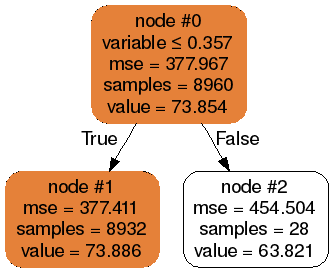

Training tree for long_description|tracks (1991/2177)
Training tree for long_description|trade (1992/2177)
Training tree for long_description|trading (1993/2177)
Training tree for long_description|traditional (1994/2177)
Training tree for long_description|train (1995/2177)
Training tree for long_description|training (1996/2177)
Training tree for long_description|transform (1997/2177)
Training tree for long_description|transport (1998/2177)
Training tree for long_description|trap (1999/2177)
Training tree for long_description|trapped (2000/2177)
Training tree for long_description|traps (2001/2177)
Training tree for long_description|travel (2002/2177)
Training tree for long_description|traverse (2003/2177)
Training tree for long_description|treacherous (2004/2177)
Training tree for long_description|treasure (2005/2177)
Training tree for long_description|treasures (2006/2177)
Training tree for long_description|tree (2007/2177)
Training tree for long_description|trees (2008/2177)
Training 

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.001060,0.000475,-378.058311,-377.949079,mse,0.8,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000121,1.648406e-05,5.110782,2.57062
11,0.000504,0.000315,-378.058311,-377.949079,mse,0.4,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000056,1.542575e-04,5.110782,2.57062
1,0.000685,0.000301,-378.058311,-377.949079,mse,0.7,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000195,1.020235e-04,5.110782,2.57062
20,0.000448,0.000202,-378.058311,-377.949079,mse,0.1,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000003,8.104673e-07,5.110782,2.57062
19,0.000444,0.000203,-378.058311,-377.949079,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000003,7.370010e-07,5.110782,2.57062
18,0.000514,0.000210,-378.058311,-377.949079,mse,0.175,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000088,1.130583e-05,5.110782,2.57062
16,0.000502,0.000212,-378.058311,-377.949079,mse,0.225,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000048,1.015450e-05,5.110782,2.57062
15,0.000463,0.000205,-378.058311,-377.949079,mse,0.25,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000004,2.657295e-06,5.110782,2.57062
14,0.000461,0.000206,-378.058311,-377.949079,mse,0.3,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000004,2.418379e-06,5.110782,2.57062
13,0.000604,0.000220,-378.058311,-377.949079,mse,0.35,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.419685,-377.751012,-384.128295,-374.904435,-371.624798,-381.19179,0.000125,5.665473e-06,5.110782,2.57062


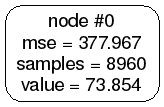

Training tree for long_description|user (2068/2177)
Training tree for long_description|users (2069/2177)
Training tree for long_description|uses (2070/2177)
Training tree for long_description|utilize (2071/2177)
Training tree for long_description|valuable (2072/2177)
Training tree for long_description|value (2073/2177)
Training tree for long_description|varied (2074/2177)
Training tree for long_description|variety (2075/2177)
Training tree for long_description|vast (2076/2177)
Training tree for long_description|vehicle (2077/2177)
Training tree for long_description|vehicles (2078/2177)
Training tree for long_description|venture (2079/2177)
Training tree for long_description|version (2080/2177)
Training tree for long_description|versions (2081/2177)
Training tree for long_description|versus (2082/2177)
Training tree for long_description|veteran (2083/2177)
Training tree for long_description|vibrant (2084/2177)
Training tree for long_description|vicious (2085/2177)
Training tree for long

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__criterion,param_clf__min_impurity_decrease,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
20,0.000492,0.000210,-377.797778,-377.491072,mse,0.1,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.793883,-376.994161,-383.752668,-374.452835,-370.844455,-381.026220,0.000003,5.227116e-06,5.316481,2.706479
19,0.000501,0.000208,-377.797778,-377.491072,mse,0.15,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",1,-378.793883,-376.994161,-383.752668,-374.452835,-370.844455,-381.026220,0.000015,2.618989e-06,5.316481,2.706479
21,0.000503,0.000209,-377.903825,-377.462186,mse,0.05,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",3,-378.793883,-376.994161,-383.752668,-374.452835,-371.162667,-380.939561,0.000006,3.128850e-06,5.178099,2.668794
23,0.000500,0.000207,-377.925336,-377.448099,mse,0.005,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-378.858409,-376.951902,-383.752668,-374.452835,-371.162667,-380.939561,0.000005,1.469711e-06,5.181885,2.671337
22,0.000507,0.000212,-377.925336,-377.448099,mse,0.01,"{'clf__criterion': 'mse', 'clf__min_impurity_d...",4,-378.858409,-376.951902,-383.752668,-374.452835,-371.162667,-380.939561,0.000003,4.899036e-07,5.181885,2.671337
36,0.000574,0.000219,-377.948259,-377.446036,friedman_mse,0.4,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",6,-378.858557,-376.950471,-383.821280,-374.448075,-371.162667,-380.939561,0.000048,6.744432e-06,5.207653,2.673205
35,0.000539,0.000221,-377.948259,-377.446036,friedman_mse,0.425,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",6,-378.858557,-376.950471,-383.821280,-374.448075,-371.162667,-380.939561,0.000033,7.011650e-06,5.207653,2.673205
34,0.000609,0.000228,-377.948259,-377.446036,friedman_mse,0.45,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",6,-378.858557,-376.950471,-383.821280,-374.448075,-371.162667,-380.939561,0.000087,1.490365e-05,5.207653,2.673205
33,0.000537,0.000224,-377.948259,-377.446036,friedman_mse,0.475,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",6,-378.858557,-376.950471,-383.821280,-374.448075,-371.162667,-380.939561,0.000034,1.420276e-05,5.207653,2.673205
32,0.000548,0.000226,-377.948259,-377.446036,friedman_mse,0.5,"{'clf__criterion': 'friedman_mse', 'clf__min_i...",6,-378.858557,-376.950471,-383.821280,-374.448075,-371.162667,-380.939561,0.000078,2.837904e-05,5.207653,2.673205


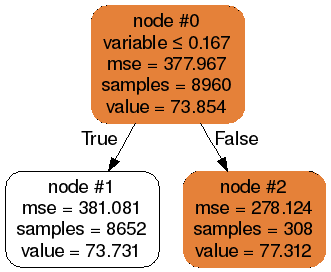

Training tree for long_description|visual (2095/2177)
Training tree for long_description|visuals (2096/2177)
Training tree for long_description|vive (2097/2177)
Training tree for long_description|voice (2098/2177)
Training tree for long_description|voiced (2099/2177)
Training tree for long_description|vr (2100/2177)
Training tree for long_description|vs (2101/2177)
Training tree for long_description|wage (2102/2177)
Training tree for long_description|wait (2103/2177)
Training tree for long_description|waiting (2104/2177)
Training tree for long_description|wake (2105/2177)
Training tree for long_description|walk (2106/2177)
Training tree for long_description|walking (2107/2177)
Training tree for long_description|wall (2108/2177)
Training tree for long_description|walls (2109/2177)
Training tree for long_description|want (2110/2177)
Training tree for long_description|wanted (2111/2177)
Training tree for long_description|wants (2112/2177)
Training tree for long_description|war (2113/2177)

In [19]:
text_vars = short_feature_names + long_feature_names

report_subset = set(random.sample(text_vars, 25))

pipelines = {}

for i, var in enumerate(text_vars):
    print('Training tree for {} ({}/{})'.format(var, i, len(text_vars)))
    display_report = True if var in report_subset else False
    pipeline = find_optimal_bins(text_df_train, y_train, var, display_report=display_report)
    pipelines[var] = pipeline
    clf = pipeline.named_steps.clf
    if display_report:
        draw_tree(clf, var)
    
    for df in (text_df_train, text_df_test):
        df['{}_binned'.format(var)] = apply_bins(pipeline, var, df)

Since the previous step takes a while to run, save its output.

In [20]:
text_df_train.to_pickle('data/text_df_train.pkl', compression='gzip')
text_df_test.to_pickle('data/text_df_test.pkl', compression='gzip')

In [19]:
with gzip.open('data/text_df_train.pkl') as f:
    text_df_train = pickle.load(f)
with gzip.open('data/text_df_test.pkl') as f:
    text_df_test = pickle.load(f)
    
display(text_df_train.shape)
display(text_df_test.shape)

(8960, 5013)

(2241, 5013)

# Run linear regression model on full dataset with all engineered features

Use the engineered features in a regression model.

In [22]:
pipeline = sklearn.pipeline.Pipeline((
    ('scaler', sklearn.preprocessing.MinMaxScaler()),
    ('clf', sklearn.linear_model.Lasso(random_state=7, max_iter=100000)),
))

param_grid = {
    'clf__alpha': [0.0025, 0.003, 0.004, 0.005, 0.006, 0.0075, 0.01, 0.025, 0.05, 0.1],
}

grid_search = sklearn.model_selection.GridSearchCV(
    pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
    n_jobs=2, cv=3, verbose=2, return_train_score=True)

grid_search.fit(text_df_train, y_train)

display_cv_results(grid_search)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] clf__alpha=0.0025 ...............................................
[CV] clf__alpha=0.0025 ...............................................
[CV] ................................ clf__alpha=0.0025, total=  27.2s
[CV] clf__alpha=0.0025 ...............................................
[CV] ................................ clf__alpha=0.0025, total=  44.8s
[CV] clf__alpha=0.003 ................................................
[CV] ................................ clf__alpha=0.0025, total= 1.4min
[CV] clf__alpha=0.003 ................................................
[CV] ................................. clf__alpha=0.003, total=  20.4s
[CV] clf__alpha=0.003 ................................................
[CV] ................................. clf__alpha=0.003, total=  31.9s
[CV] clf__alpha=0.004 ................................................
[CV] ................................. clf__alpha=0.003, total= 1.2min
[CV] clf__alpha=

[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  6.7min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
7,7.775800,0.667536,-267.462448,-225.573395,0.025,{'clf__alpha': 0.025},1,-263.011554,-226.550442,-275.204050,-222.325623,-264.170638,-227.844120,0.463585,0.038288,5.495009,2.356469
6,19.087433,0.644857,-270.204923,-181.976416,0.01,{'clf__alpha': 0.01},2,-267.353359,-183.280873,-276.938710,-178.543333,-266.321401,-184.105042,4.654171,0.024852,4.780504,2.450763
5,23.413875,0.612902,-277.139289,-168.034566,0.0075,{'clf__alpha': 0.0075},3,-274.213173,-168.899953,-283.193665,-165.252756,-274.009981,-169.950988,4.957574,0.006286,4.282253,2.013292
8,6.524201,0.670698,-278.110748,-254.277908,0.05,{'clf__alpha': 0.05},4,-273.767449,-256.418222,-285.993286,-251.066893,-274.570323,-255.348609,0.124938,0.037235,5.583891,2.312139
4,30.315332,0.632397,-284.846049,-157.842047,0.006,{'clf__alpha': 0.006},5,-281.918060,-158.822874,-289.872051,-155.416517,-282.747332,-159.286748,8.299750,0.014379,3.570304,1.725532
9,4.950548,0.615222,-292.228484,-280.504727,0.1,{'clf__alpha': 0.1},6,-288.271089,-282.933080,-299.704326,-276.681097,-288.708857,-281.900006,0.656579,0.030722,5.289681,2.736412
3,31.481180,0.640583,-292.487261,-150.263503,0.005,{'clf__alpha': 0.005},7,-289.538993,-151.220851,-296.289621,-148.089214,-291.632883,-151.480444,7.531875,0.023633,2.821501,1.541103
2,30.682478,0.602125,-303.760571,-141.886898,0.004,{'clf__alpha': 0.004},8,-300.574459,-142.696653,-306.374537,-139.881643,-304.332908,-143.082398,11.084914,0.001848,2.402327,1.426648
1,40.453218,0.609204,-321.293999,-132.424769,0.003,{'clf__alpha': 0.003},9,-317.987173,-133.254991,-322.103405,-130.823798,-323.792254,-133.195518,21.638922,0.009559,2.437992,1.132318
0,51.532773,0.611695,-333.661542,-127.034615,0.0025,{'clf__alpha': 0.0025},10,-330.857997,-127.697392,-333.115595,-125.650887,-337.012156,-127.755567,23.893823,0.013163,2.541846,0.978732


# Visualize model performance

Visualizing regression results in a high-dimensional space is tricky, so we'll try to find a few ways to look at the predictions.

Plot the residuals to see if their distribution appears to be random.

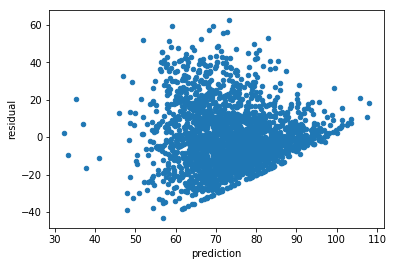

In [27]:
predictions = grid_search.predict(text_df_test)
residuals = predictions - y_test

residual_df = pd.DataFrame({'prediction': predictions, 'residual': residuals})

residual_df.plot(x='prediction', y='residual', kind='scatter')

There are sharp lines along the boundaries of the actual data (since a proportion is bounded between 0 and 1), but the residuals otherwise look randomly distributed.

Plot the distribution of predicted values and distribution of actual values to see whether the model is closely approximating the real distribution.

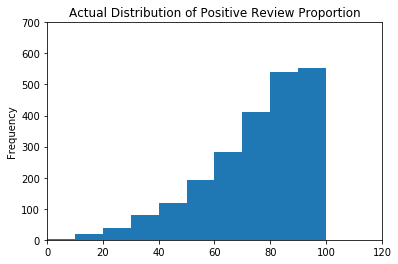

In [24]:
y_test.plot(kind='hist', title='Actual Distribution of Positive Review Proportion',
            ylim=(0, 700), xlim=(0,120))

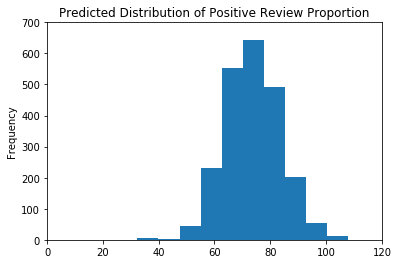

In [25]:
residual_df['prediction'].plot(kind='hist', title='Predicted Distribution of Positive Review Proportion',
                              ylim=(0, 700), xlim=(0, 120))

The distributions peak around the same area, but the assumption of a normal distribution inherent in ordinary least-squares regression is clearly incorrect.  We hope to more accurately match the true data distribution using more advanced techniques later.

Finally, check the R^2 value for our model on our test dataset.

In [26]:
grid_search.best_estimator_.named_steps.clf.score(text_df_test, y_test)

-4.0048640233069435e+18

The value is huge because of a ton of variance in the test set that wasn't present in the training set.  Hopefully, we can improve on this with a better model.

# Set parameter grid for AdaBoost regression model

Set a wide grid to search across to find optimal hyperparameters.

In [77]:
pipeline = sklearn.pipeline.Pipeline((
    ('scaler', sklearn.preprocessing.MinMaxScaler()),
    ('clf', sklearn.ensemble.AdaBoostRegressor(random_state=7,
                                               base_estimator=sklearn.tree.DecisionTreeRegressor())),
))

param_grid = {
    'clf__n_estimators': [5, 10, 25, 50],
    'clf__base_estimator__max_depth': [1, 2, 3, 5, 50],
    'clf__base_estimator__min_impurity_decrease': [0.25, 0.5, 1, 5, 10],
    'clf__loss': ['linear', 'square', 'exponential']
    
}

grid_search = sklearn.model_selection.GridSearchCV(
    pipeline, param_grid=param_grid, scoring='neg_mean_squared_error',
    n_jobs=1, cv=3, return_train_score=True, verbose=2)

# Run grid search using AdaBoost regression model on full data set with all engineered features

This will take a while...

In [78]:
def display_importances(grid_search):
    clf = grid_search.best_estimator_.named_steps.clf
    
    feature_names = text_df_train.columns
    importances_df = pd.DataFrame({'importance': clf.feature_importances_}, index=feature_names)
    display(importances_df[importances_df['importance'] > 0.0].sort_values(by='importance', ascending=False))

In [79]:
grid_search.fit(text_df_train, y_train)

display_cv_results(grid_search)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5, total=   5.7s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5, total=   5.7s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5, total=   5.7s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=10, total=   8.6s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=10, total=   8.6s
[CV] clf__base_estimator__max_depth=1, clf__bas

[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=exponential, clf__n_estimators=25, total=  17.2s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=exponential, clf__n_estimators=50, total=  31.4s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=exponential, clf__n_estimators=50, total=  31.2s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=exponential, clf__n_estimators=50, total=  31.3s
[CV] clf_

[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10, total=   8.6s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10, total=   8.6s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10, total=   8.6s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=25, total=  17.2s
[CV] clf__base_e

[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=1, clf__loss=square, clf__n_estimators=50, total=  17.3s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=1, clf__loss=square, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=1, clf__loss=square, clf__n_estimators=50, total=  28.8s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=5, total=   5.7s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=5, total=   5.7s
[CV] clf__base_estimator__max_depth=1, clf__base_

[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=10, total=   8.4s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=25, total=  16.4s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=25, total=  16.3s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=25, total=  16.4s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_i

[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=5, total=   5.6s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=5, total=   5.6s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=5, total=   5.6s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=1, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=10, total=   8.4s
[CV] clf__base_estimator__max_depth=1, clf__base_estimator__min

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=25, total=  13.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=25, total=  14.6s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=50, total=  12.3s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=50, total=  13.8s
[CV] clf__base_estimator__max_depth=2, clf__

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=5, total=   6.7s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=5, total=   6.7s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=10, total=  10.7s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=10, total=  10.7s
[CV] clf__base_estimator__max_depth=2, clf__base_estim

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=25, total=  22.5s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=50, total=  41.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=50, total=  41.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=50, total=  41.8s
[CV] clf__base_e

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=10, total=  10.7s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=10, total=  10.7s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=10, total=  10.7s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=25, total=  22.5s
[CV] clf__base_estimator__max_

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=50, total=  39.6s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=50, total=  39.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=5, total=   6.7s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=5, total=   6.7s
[CV] clf__base_estimator__max_depth=2, clf__base_

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=10, total=  10.5s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=25, total=  21.6s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=25, total=  21.6s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=25, total=  21.7s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator

[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=5, total=   7.7s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=5, total=   7.7s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=5, total=   7.7s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=10, total=  12.5s
[CV] clf__base_estimator__max_depth=3, clf__base_

[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=25, total=  25.4s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=25, total=  27.4s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=25, total=  18.6s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=50, total=  25.4s
[CV] clf__base_estimator__max_depth=3, clf__base_es

[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=5, total=   7.7s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=5, total=   7.7s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=10, total=  12.7s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=10, total=  12.6s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impu

[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=25, total=  27.4s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=50, total=  51.5s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=50, total=  51.5s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=50, total=  51.6s
[CV] clf__base_estimator__max_

[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=10, total=  12.6s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=10, total=  12.6s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=10, total=  12.6s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=25, total=  27.3s
[CV] clf__base_estimator__max_

[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=50, total=  49.6s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=10, clf__loss=square, clf__n_estimators=50, total=  49.7s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=5, total=   7.3s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=5, total=   7.5s
[CV] clf__base_estimator__max_depth=3, clf

[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=10, total=  16.3s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=25, total=  36.1s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=25, total=  36.1s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=25, total=  36.3s
[CV] clf__base_estimator__max_depth=5, clf__

[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=50, total= 1.2min
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=5, total=   9.5s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=5, total=   9.5s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=5, total=   9.5s
[CV] clf__base_estimator__max_depth=5, clf__base_estimato

[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=25, total=  36.7s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=25, total=  36.7s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=25, total=  36.8s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=50, total=  57.0s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_i

[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=5, total=   9.0s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=5, total=   8.9s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=10, total=  15.7s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=10, total=  15.8s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impu

[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=25, total=  35.9s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=50, total= 1.2min
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=50, total= 1.2min
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=50, total= 1.2min
[CV] clf__base_estimator__max_

[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=10, total=  14.3s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=10, total=  14.5s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=10, total=  14.7s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=25, total=  34.4s
[CV] clf__base_estimato

[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=50, total= 3.3min
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=50, total= 3.3min
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=50, total= 3.1min
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=exponential, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=exponential, clf__n_estimators=5, total=  18.7s
[CV] clf__base_estimator__max

[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=10, total=  34.6s
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=10, total=  38.4s
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=10, total=  35.8s
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=25, total= 1.5min
[CV] clf__base_estimator__max_depth=50, clf_

[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=50, total= 2.8min
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=50, total= 3.0min
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=50, total= 2.8min
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=1, clf__loss=square, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=1, clf__loss=square, clf__n_estimators=5, total=  16.8s
[CV] clf__base_estimator__max_depth=50, clf__base_estimator_

[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=10, total=  23.5s
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=10, total=  22.9s
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=25, total= 1.1min
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=25, total= 1.2min
[CV] clf__base_estimator__max_depth=50, clf__base_estimato

[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=5, clf__loss=exponential, clf__n_estimators=50, total= 2.4min
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=10, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=10, clf__loss=linear, clf__n_estimators=5, total=   8.6s
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=10, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=10, clf__loss=linear, clf__n_estimators=5, total=   8.7s
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=10, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=10, clf__loss=linear, clf__n_estimators=5, total=   8.8s
[CV] clf__base_estimator__max_depth=50, clf__base_est

[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=25, total=  55.8s
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=25, total=  56.1s
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=25, total=  54.0s
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=50, total= 2.1min
[CV] clf__base_e

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed: 488.9min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__base_estimator__max_depth,param_clf__base_estimator__min_impurity_decrease,param_clf__loss,param_clf__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
255,179.644250,0.812378,-257.561080,-49.429146,50,0.5,linear,50,"{'clf__base_estimator__max_depth': 50, 'clf__b...",1,-256.900673,-50.170837,-264.551610,-49.528558,-251.228837,-48.588044,2.622372,0.001734,5.458861,0.649985
263,175.810742,0.811319,-259.508902,-50.254420,50,0.5,exponential,50,"{'clf__base_estimator__max_depth': 50, 'clf__b...",2,-256.588199,-51.340619,-268.448801,-49.173430,-253.487690,-50.249212,4.594085,0.001108,6.447456,0.884759
275,170.184797,0.807904,-260.937380,-80.532033,50,1,exponential,50,"{'clf__base_estimator__max_depth': 50, 'clf__b...",3,-258.711447,-82.210708,-267.880929,-78.713342,-256.218184,-80.672050,4.987425,0.000782,5.014626,1.431223
267,171.250389,0.807329,-261.214596,-79.257933,50,1,linear,50,"{'clf__base_estimator__max_depth': 50, 'clf__b...",4,-257.895080,-79.696316,-270.345385,-79.322289,-255.401376,-78.755195,5.459832,0.001036,6.536743,0.386897
251,180.233083,0.815666,-261.798626,-29.299408,50,0.25,exponential,50,"{'clf__base_estimator__max_depth': 50, 'clf__b...",5,-259.856338,-29.352019,-271.062377,-29.423978,-254.474712,-29.122226,5.404410,0.001042,6.909590,0.128684
243,185.960010,0.816951,-262.076925,-29.424624,50,0.25,linear,50,"{'clf__base_estimator__max_depth': 50, 'clf__b...",6,-261.883948,-29.472509,-271.277663,-29.659356,-253.066147,-29.142006,5.602223,0.000915,7.435865,0.213904
254,88.400850,0.673396,-266.140853,-59.109649,50,0.5,linear,25,"{'clf__base_estimator__max_depth': 50, 'clf__b...",7,-266.825020,-59.590811,-276.253317,-59.036032,-255.340606,-58.702104,2.830637,0.000201,8.551039,0.366528
274,81.385996,0.671039,-269.217538,-95.680278,50,1,exponential,25,"{'clf__base_estimator__max_depth': 50, 'clf__b...",8,-268.011256,-98.021208,-275.168683,-94.444787,-264.471086,-94.574837,3.965130,0.000348,4.449687,1.656139
266,81.645807,0.670383,-270.863101,-92.409931,50,1,linear,25,"{'clf__base_estimator__max_depth': 50, 'clf__b...",9,-266.926703,-92.728290,-279.794890,-92.288189,-265.866038,-92.213313,2.212935,0.000734,6.331082,0.227180
271,177.318015,0.808543,-271.813067,-81.620551,50,1,square,50,"{'clf__base_estimator__max_depth': 50, 'clf__b...",10,-274.550209,-82.556973,-279.788849,-81.756305,-261.096557,-80.548375,4.060016,0.001575,7.872546,0.825606


Since this model provides feature importances, examine them to see which features most positively and negatively influence a game's score.

In [80]:
display_importances(grid_search)

(pd.DataFrame(grid_search.cv_results_)
                .sort_values('mean_test_score', ascending=False)).to_csv('data/results_final.csv')

,importance
tags|Great Soundtrack,0.011449
details|Steam Cloud,0.010733
release_date_loglog,0.007273
release_date,0.007171
release_date_squared,0.007170
publisher|United Independent Entertainment GmbH,0.007058
release_date_winsor99,0.006931
tags|Puzzle,0.006643
reviews_all_time_loglog,0.006447
details|Room-Scale,0.006395


The importance doesn't tell us whether the feature contributes positively or negatively to the outcome; get a rough idea of that using the correlation with the outcome.

In [29]:
top_10_features = (
    'tags|Great Soundtrack',
    'details|Steam Cloud',
    'release_date_loglog',
    'release_date',
    'release_date_squared',
    'publisher|United Independent Entertainment GmbH',
    'release_date_winsor99',
    'tags|Puzzle',
    'reviews_all_time_loglog',
    'details|Room-Scale')

all_df = pd.concat([text_df_train, text_df_test], axis=0)
all_y = pd.concat([y_train, y_test], axis=0)

for feature in top_10_features:
    print('{} correlation with outcome: {}'.format(
        feature, all_df[feature].corr(all_y)))    

tags|Great Soundtrack correlation with outcome: 0.2194827351921421
details|Steam Cloud correlation with outcome: 0.18733540851854089
release_date_loglog correlation with outcome: -0.06891340352102028
release_date correlation with outcome: -0.06449859638897475
release_date_squared correlation with outcome: -0.05949027536923504
publisher|United Independent Entertainment GmbH correlation with outcome: -0.1196783448164822
release_date_winsor99 correlation with outcome: -0.06448380740774853
tags|Puzzle correlation with outcome: 0.13808210459344572
reviews_all_time_loglog correlation with outcome: 0.22104495366119684
details|Room-Scale correlation with outcome: 0.07716073004141169


# Visualize model performance

Plot the residuals to see if their distribution appears to be random.

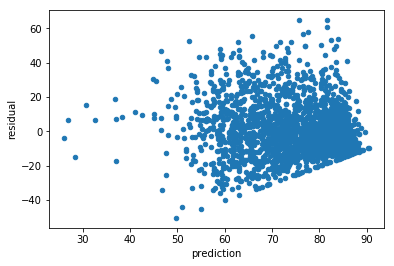

In [19]:
predictions = grid_search.predict(text_df_test)
residuals = predictions - y_test

residual_df = pd.DataFrame({'prediction': predictions, 'residual': residuals})

residual_df = residual_df[(residual_df['prediction'] <= 150) & (residual_df['prediction'] >= 0)]
residual_df.plot(x='prediction', y='residual', kind='scatter')

There are sharp lines along the boundaries of the actual data (since a proportion is bounded between 0 and 1), but the residuals otherwise look randomly distributed.

Plot the distribution of predicted values and distribution of actual values to see whether the model is closely approximating the real distribution.

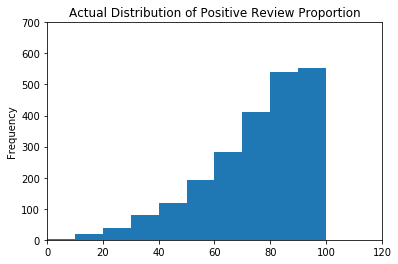

In [20]:
y_test.plot(kind='hist', title='Actual Distribution of Positive Review Proportion',
            ylim=(0, 700), xlim=(0,120))

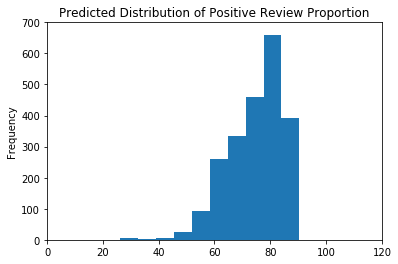

In [21]:
residual_df['prediction'].plot(kind='hist', title='Predicted Distribution of Positive Review Proportion',
                              ylim=(0, 700), xlim=(0, 120))

The Adaboost regressor does a much better job matching the non-normal distribution of the real data; however, it doesn't appear to predict any results above 90.

Finally, check the R^2 value for our model on our test dataset.

In [22]:
grid_search.best_estimator_.named_steps.clf.score(text_df_test, y_test)

-0.26547909391675639

This is much better than the lasso regression value, although it's still negative, indicating a good amount of variance is unaccounted for in the test set.

# Extra GridSearch results from different parameter grids

In [75]:
grid_search.fit(text_df_train, y_train)

display_cv_results(grid_search)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=20 
[CV]  clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=20, total= 1.1min
[CV] clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=20 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=20, total= 1.1min
[CV] clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=20 
[CV]  clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=20, total= 1.0min
[CV] clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=50, total= 2.8min
[CV] clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=50, total= 2.8min
[CV] clf__base_estimator__max_depth=20, clf__base_estimato

[CV]  clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=20, total=  42.0s
[CV] clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=50, total= 2.0min
[CV] clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=50, total= 2.1min
[CV] clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=50, total= 2.1min
[CV] clf__base_e

[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=20, total=  53.3s
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=50, total= 2.5min
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=50, total= 2.6min
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=5, clf__loss=linear, clf__n_estimators=50, total= 2.5min
[CV] clf__base_estimator__max_depth=50, clf__base_estimato

[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=20, clf__loss=exponential, clf__n_estimators=20, total=  32.5s
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=20, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=20, clf__loss=exponential, clf__n_estimators=50, total= 1.7min
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=20, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=20, clf__loss=exponential, clf__n_estimators=50, total= 1.7min
[CV] clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=20, clf__loss=exponential, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=50, clf__base_estimator__min_impurity_decrease=20, clf__loss=exponential, clf__n_estimators=50, total= 1.8min


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 152.3min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__base_estimator__max_depth,param_clf__base_estimator__min_impurity_decrease,param_clf__loss,param_clf__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
19,174.957523,0.839206,-260.937380,-80.532033,50,1,exponential,50,"{'clf__base_estimator__max_depth': 50, 'clf__b...",1,-258.711447,-82.210708,-267.880929,-78.713342,-256.218184,-80.672050,4.319309,0.003077,5.014626,1.431223
17,175.318400,0.838439,-261.214596,-79.257933,50,1,linear,50,"{'clf__base_estimator__max_depth': 50, 'clf__b...",2,-257.895080,-79.696316,-270.345385,-79.322289,-255.401376,-78.755195,6.577216,0.003901,6.536743,0.386897
3,163.488588,0.862827,-265.115397,-105.386059,20,1,exponential,50,"{'clf__base_estimator__max_depth': 20, 'clf__b...",3,-261.686513,-103.823772,-270.808038,-107.673543,-262.850881,-104.660862,1.735624,0.000221,4.053609,1.653202
1,165.145839,0.870348,-265.994601,-102.496196,20,1,linear,50,"{'clf__base_estimator__max_depth': 20, 'clf__b...",4,-265.635073,-102.008930,-271.075395,-100.331618,-261.271752,-105.148039,0.822457,0.004919,4.010276,1.996255
18,65.945290,0.677669,-273.802547,-103.969950,50,1,exponential,20,"{'clf__base_estimator__max_depth': 50, 'clf__b...",5,-273.051688,-104.696414,-280.063754,-104.374169,-268.290355,-102.839268,3.036417,0.009462,4.835577,0.810265
16,65.834424,0.672318,-275.906062,-100.980870,50,1,linear,20,"{'clf__base_estimator__max_depth': 50, 'clf__b...",6,-270.957572,-101.671881,-284.715393,-101.557738,-272.043927,-99.712990,1.927066,0.000992,6.245426,0.897736
0,62.606854,0.705496,-277.192543,-120.963711,20,1,linear,20,"{'clf__base_estimator__max_depth': 20, 'clf__b...",7,-276.502204,-121.775116,-283.391578,-124.038705,-271.682002,-117.077312,1.675068,0.006924,4.805144,2.899314
2,62.844485,0.693580,-278.219283,-126.758524,20,1,exponential,20,"{'clf__base_estimator__max_depth': 20, 'clf__b...",8,-276.508045,-126.429522,-284.724114,-130.320481,-273.424085,-123.525570,2.438083,0.006745,4.769172,2.783749
23,147.744418,0.819664,-283.685601,-179.445895,50,5,exponential,50,"{'clf__base_estimator__max_depth': 50, 'clf__b...",9,-280.676040,-179.056528,-290.629021,-177.626733,-279.750425,-181.654423,10.522928,0.001265,4.924669,1.667189
5,141.284176,0.843451,-284.756179,-184.129842,20,5,linear,50,"{'clf__base_estimator__max_depth': 20, 'clf__b...",10,-280.959699,-182.880323,-293.196866,-183.963047,-280.110417,-185.546154,1.079232,0.009436,5.979027,1.094693


In [76]:
display_importances(grid_search)

(pd.DataFrame(grid_search.cv_results_)
                .sort_values('mean_test_score', ascending=False)).to_csv('data/results_3.csv')

,importance
tags|Great Soundtrack,0.013839
details|Steam Cloud,0.011439
tags|Puzzle,0.007532
publisher|United Independent Entertainment GmbH,0.007476
details|Room-Scale,0.007219
release_date_sqrt,0.007076
release_date_winsor95,0.007032
reviews_all_time_log,0.006974
reviews_all_time_sqrt,0.006972
release_date_squared,0.006937


In [70]:
grid_search.fit(text_df_train, y_train)

display_cv_results(grid_search)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5, total=   9.9s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s


[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5, total=   9.6s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5, total=   9.7s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=10, total=  16.6s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=10, total=  16.5s
[CV] clf__base_estimator__max_depth=5, clf__bas

[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=5, total=  10.6s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10, total=  18.3s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10, total=  18.3s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10, total=  18.2s
[CV] clf__base_es

[CV]  clf__base_estimator__max_depth=10, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=10, total=  26.9s
[CV] clf__base_estimator__max_depth=10, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=10, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=10, total=  26.8s
[CV] clf__base_estimator__max_depth=10, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=10, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=10, total=  26.9s
[CV] clf__base_estimator__max_depth=10, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=exponential, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=10, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=exponential, clf__n_estimators=5, total=  14.6s
[CV] clf__base_estimator__max

[CV]  clf__base_estimator__max_depth=10, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=10, total=  24.7s
[CV] clf__base_estimator__max_depth=10, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=10, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=10, total=  24.7s
[CV] clf__base_estimator__max_depth=10, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=10, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=10, total=  24.7s
[CV] clf__base_estimator__max_depth=10, clf__base_estimator__min_impurity_decrease=1, clf__loss=square, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=10, clf__base_estimator__min_impurity_decrease=1, clf__loss=square, clf__n_estimators=5, total=  13.6s
[CV] clf__base_estimator__max_depth=10, clf__base_estimator_

[CV]  clf__base_estimator__max_depth=15, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=exponential, clf__n_estimators=10, total=  29.7s
[CV] clf__base_estimator__max_depth=15, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=15, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=exponential, clf__n_estimators=10, total=  29.7s
[CV] clf__base_estimator__max_depth=15, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=15, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=5, total=  16.2s
[CV] clf__base_estimator__max_depth=15, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=15, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=5, total=  16.4s
[CV] clf__base_estimator__max_

[CV]  clf__base_estimator__max_depth=15, clf__base_estimator__min_impurity_decrease=1, clf__loss=square, clf__n_estimators=10, total=  28.5s
[CV] clf__base_estimator__max_depth=15, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=15, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=5, total=  15.9s
[CV] clf__base_estimator__max_depth=15, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=15, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=5, total=  14.8s
[CV] clf__base_estimator__max_depth=15, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=15, clf__base_estimator__min_impurity_decrease=1, clf__loss=exponential, clf__n_estimators=5, total=  14.4s
[CV] clf__base_estimator__max_dept

[CV]  clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=linear, clf__n_estimators=10, total=  31.9s
[CV] clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=5, total=  17.6s
[CV] clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=5, total=  17.3s
[CV] clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=20, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=square, clf__n_estimators=5, total=  17.0s
[CV] clf__base_estimator__max_depth=20, clf__base_

[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed: 77.1min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__base_estimator__max_depth,param_clf__base_estimator__min_impurity_decrease,param_clf__loss,param_clf__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
59,32.838411,0.605904,-289.551951,-93.270919,20,0.25,exponential,10,"{'clf__base_estimator__max_depth': 20, 'clf__b...",1,-285.051744,-98.926520,-297.285745,-97.407993,-286.317280,-83.478243,0.631219,0.010365,5.493425,6.952163
43,28.448281,0.606574,-290.249641,-156.366574,15,0.5,linear,10,"{'clf__base_estimator__max_depth': 15, 'clf__b...",2,-293.306574,-163.816676,-293.510599,-158.110372,-283.929633,-147.172674,0.261163,0.005514,4.468948,6.905859
23,26.022119,0.658842,-291.263650,-213.981912,10,0.25,exponential,10,"{'clf__base_estimator__max_depth': 10, 'clf__b...",3,-286.717485,-206.848191,-298.228667,-224.893044,-288.843989,-210.204501,0.371453,0.001279,5.001341,7.836062
71,30.149899,0.602828,-291.452470,-158.921220,20,1,exponential,10,"{'clf__base_estimator__max_depth': 20, 'clf__b...",4,-290.895696,-164.968814,-297.575598,-160.199815,-285.884252,-151.595032,0.888841,0.003281,4.789051,5.534173
47,29.103855,0.611822,-291.525082,-155.181019,15,0.5,exponential,10,"{'clf__base_estimator__max_depth': 15, 'clf__b...",5,-295.930209,-170.379451,-295.858309,-153.910740,-282.783802,-141.252867,0.579657,0.002893,6.180054,11.924755
37,28.528545,0.608825,-291.587205,-134.103929,15,0.25,linear,10,"{'clf__base_estimator__max_depth': 15, 'clf__b...",6,-291.353614,-128.788621,-292.580076,-133.381275,-290.827670,-140.141890,0.489218,0.002744,0.734220,4.663036
53,27.246060,0.608184,-292.181962,-185.198001,15,1,exponential,10,"{'clf__base_estimator__max_depth': 15, 'clf__b...",7,-290.118045,-180.042763,-298.879829,-189.639067,-287.546461,-185.912173,0.452565,0.002950,4.851451,3.950088
67,28.010925,0.592709,-292.229993,-149.637901,20,1,linear,10,"{'clf__base_estimator__max_depth': 20, 'clf__b...",8,-291.612749,-148.360001,-300.263544,-152.351349,-284.811203,-148.202352,0.671393,0.000820,6.323299,1.919777
65,30.439036,0.594029,-292.503731,-128.896983,20,0.5,exponential,10,"{'clf__base_estimator__max_depth': 20, 'clf__b...",9,-295.180946,-136.199637,-294.576065,-125.927557,-287.752592,-124.563755,0.376363,0.000435,3.368066,5.193686
41,29.522370,0.607522,-293.052172,-132.751721,15,0.25,exponential,10,"{'clf__base_estimator__max_depth': 15, 'clf__b...",10,-287.371279,-126.752701,-300.754920,-137.383689,-291.029639,-134.118773,0.589788,0.004060,5.648151,4.446429


In [72]:
display_importances(grid_search)

(pd.DataFrame(grid_search.cv_results_)
                .sort_values('mean_test_score', ascending=False)).to_csv('data/results_2.csv')

,importance
tags|Great Soundtrack,0.024795
reviews_all_time_log,0.016709
reviews_all_time_winsor95,0.013973
details|Steam Cloud,0.013789
num_achievements,0.013375
release_date_squared,0.010808
release_date_log,0.010199
reviews_all_time_sqrt,0.009309
num_achievements_log,0.009223
details|Full controller support,0.008981


In [63]:
grid_search.fit(text_df_train, y_train)

display_cv_results(grid_search)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5, total=   7.0s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5, total=   6.9s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=5, total=   6.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=10, total=  10.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=10, total=  10.8s
[CV] clf__base_estimator__max_depth=2, clf__bas

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=5, total=   6.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10, total=  10.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10, total=  10.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10, total=  10.8s
[CV] clf__base_es

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=square, clf__n_estimators=10, total=  10.6s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=square, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=square, clf__n_estimators=10, total=  10.6s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=square, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=square, clf__n_estimators=10, total=  10.6s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=exponential, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=exponential, clf__n_estimators=5, total=   6.8s
[CV] clf__base_estimator__max_depth=2, clf_

[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=10, total=  12.8s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=linear, clf__n_estimators=10, total=  12.8s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=5, total=   7.8s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=5, total=   7.8s
[CV] clf__base_estimator__max_depth=3, clf__base

[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=0.5, clf__loss=exponential, clf__n_estimators=10, total=  12.8s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=5, total=   7.8s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=5, total=   7.8s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=5, total=   7.8s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_

[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=exponential, clf__n_estimators=5, total=   7.8s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=exponential, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=exponential, clf__n_estimators=5, total=   7.8s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=exponential, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=exponential, clf__n_estimators=5, total=   7.8s
[CV] clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=3, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=exponential, clf__n_estimators=10, total=  12.8s
[CV] clf__base_estima

[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=5, total=   9.6s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=5, total=   9.6s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=10, total=  16.4s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=0.25, clf__loss=square, clf__n_estimators=10, total=  16.3s
[CV] clf__base_estimator__max_depth=5, clf__bas

[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=5, total=  10.7s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=10, total=  18.5s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=10, total=  18.5s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1, clf__loss=linear, clf__n_estimators=10, total=  18.8s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_im

[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=exponential, clf__n_estimators=10, total=  17.2s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=exponential, clf__n_estimators=10, total=  17.8s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=1.5, clf__loss=exponential, clf__n_estimators=10, total=  18.1s
[CV] clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=2, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=5, clf__base_estimator__min_impurity_decrease=2, clf__loss=linear, clf__n_estimators=5, total=  10.7s
[CV] clf__base_estimator__max_de

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 55.2min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__base_estimator__max_depth,param_clf__base_estimator__min_impurity_decrease,param_clf__loss,param_clf__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
70,10.129956,0.612978,-314.993237,-294.671255,5,0.5,exponential,5,"{'clf__base_estimator__max_depth': 5, 'clf__ba...",1,-310.247646,-297.273093,-322.584435,-291.321406,-312.146677,-295.419266,0.024065,0.002367,5.423927,2.486669
89,17.458369,0.628855,-316.467484,-295.143655,5,2,exponential,10,"{'clf__base_estimator__max_depth': 5, 'clf__ba...",2,-308.216741,-293.487251,-320.974101,-293.738892,-320.212864,-298.204822,0.056167,0.002393,5.842915,2.167009
65,16.375398,0.599562,-316.869826,-291.787236,5,0.25,exponential,10,"{'clf__base_estimator__max_depth': 5, 'clf__ba...",3,-312.146277,-293.258807,-318.982835,-287.426682,-319.481240,-294.676221,0.246095,0.008252,3.346524,3.137206
88,9.875499,0.600821,-317.381892,-301.330564,5,2,exponential,5,"{'clf__base_estimator__max_depth': 5, 'clf__ba...",4,-307.706864,-298.732913,-325.226214,-301.150288,-319.213211,-304.108491,0.073166,0.001637,7.268880,2.198270
71,17.833081,0.642463,-317.579488,-293.924460,5,0.5,exponential,10,"{'clf__base_estimator__max_depth': 5, 'clf__ba...",5,-311.065669,-292.070766,-319.121286,-291.817797,-322.553175,-297.884816,0.045007,0.003405,4.814700,2.802299
83,17.087209,0.621451,-317.768124,-296.341016,5,1.5,exponential,10,"{'clf__base_estimator__max_depth': 5, 'clf__ba...",6,-316.036686,-297.943122,-320.530756,-292.972506,-316.736583,-298.107421,0.363077,0.011518,1.974423,2.382841
77,17.877461,0.637098,-318.985196,-296.601474,5,1,exponential,10,"{'clf__base_estimator__max_depth': 5, 'clf__ba...",7,-314.872362,-299.122099,-322.565912,-291.228762,-319.517492,-299.453562,0.228118,0.004305,3.163517,3.801491
76,10.077158,0.608445,-319.230238,-300.023515,5,1,exponential,5,"{'clf__base_estimator__max_depth': 5, 'clf__ba...",8,-316.101666,-301.100251,-324.985968,-299.423552,-316.602200,-299.546741,0.024956,0.000195,4.075382,0.763026
82,9.415708,0.561441,-319.529595,-296.666805,5,1.5,exponential,5,"{'clf__base_estimator__max_depth': 5, 'clf__ba...",9,-317.096250,-300.075095,-323.491218,-292.263892,-318.000806,-297.661427,0.403737,0.001096,2.825757,3.265546
84,10.069374,0.609152,-320.004935,-300.428544,5,2,linear,5,"{'clf__base_estimator__max_depth': 5, 'clf__ba...",10,-309.766393,-296.551830,-327.296058,-300.981959,-322.953341,-303.751843,0.032603,0.005058,7.454238,2.965327


In [66]:
display_importances(grid_search)

(pd.DataFrame(grid_search.cv_results_)
                .sort_values('mean_test_score', ascending=False)).to_csv('data/results_1.csv')

,importance
tags|Great Soundtrack,0.091749
reviews_all_time,0.072673
reviews_all_time_log,0.054100
num_achievements_log,0.051607
reviews_last_30_days_binned,0.045096
details|Full controller support,0.043929
release_date_winsor99,0.036371
tags|Puzzle,0.032968
details|Steam Cloud,0.029745
release_date_winsor90,0.028054


In [58]:
grid_search.fit(text_df_train, y_train)

display_cv_results(grid_search)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=linear, clf__n_estimators=5, total=   6.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=linear, clf__n_estimators=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=linear, clf__n_estimators=5, total=   6.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=linear, clf__n_estimators=5 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=linear, clf__n_estimators=5, total=   6.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=linear, clf__n_estimators=10, total=  10.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=linear, clf__n_estimators=10, total=  10.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impu

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=exponential, clf__n_estimators=5, total=   6.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=exponential, clf__n_estimators=10, total=  10.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=exponential, clf__n_estimators=10, total=  10.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=exponential, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=2, clf__loss=exponential, clf__n_estimators=10, total=  10.8s
[CV] clf__base_estimator__max_d

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=10, total=  10.6s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=10, total=  10.6s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=10, total=  10.7s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=15 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=5, clf__loss=square, clf__n_estimators=15, total=  14.4s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_i

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=linear, clf__n_estimators=10, total=  10.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=linear, clf__n_estimators=10, total=  10.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=linear, clf__n_estimators=15 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=linear, clf__n_estimators=15, total=  14.7s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=linear, clf__n_estimators=15 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=linear, clf__n_estimators=15, total=  14.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=10, total=  10.7s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=15 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=15, total=  14.7s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=15 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=15, total=  14.7s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=15 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=10, clf__loss=exponential, clf__n_estimators=15, total=  14.7s
[CV] clf__base_estimato

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=25, clf__loss=square, clf__n_estimators=15, total=  14.2s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=25, clf__loss=square, clf__n_estimators=15 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=25, clf__loss=square, clf__n_estimators=15, total=  14.1s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=25, clf__loss=square, clf__n_estimators=15 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=25, clf__loss=square, clf__n_estimators=15, total=  14.2s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=25, clf__loss=square, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=25, clf__loss=square, clf__n_estimators=25, total=  21.6s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=15, total=  14.0s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=15 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=15, total=  14.2s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=25, total=  18.0s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=25, total=  17.2s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=exponential, clf__n_estimators=15, total=  14.0s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=exponential, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=exponential, clf__n_estimators=25, total=  21.9s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=exponential, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=exponential, clf__n_estimators=25, total=  21.8s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=exponential, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=exponential, clf__n_estimators=25, total=  21.8s
[CV] clf__base_estimato

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=100, clf__loss=square, clf__n_estimators=25, total=  21.2s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=100, clf__loss=square, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=100, clf__loss=square, clf__n_estimators=25, total=  21.2s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=100, clf__loss=square, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=100, clf__loss=square, clf__n_estimators=25, total=  21.1s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=100, clf__loss=square, clf__n_estimators=50 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=100, clf__loss=square, clf__n_estimators=50, total=  39.2s
[CV] clf__base_estimator__max_depth=2, clf__base_es

[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 79.0min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__base_estimator__max_depth,param_clf__base_estimator__min_impurity_decrease,param_clf__loss,param_clf__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
10,6.235104,0.587459,-343.874458,-338.212566,2,2,exponential,5,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",1,-338.612918,-341.369785,-348.169838,-335.010593,-344.840942,-338.257320,0.008100,0.001032,3.961192,2.596322
0,6.226869,0.591177,-346.924234,-341.306157,2,2,linear,5,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",2,-345.035732,-344.303085,-354.112626,-339.890249,-341.622568,-339.725138,0.013083,0.000787,5.270894,2.120220
15,6.209668,0.585768,-347.272901,-342.243308,2,5,linear,5,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",3,-342.448725,-342.572443,-353.292461,-341.290528,-346.077118,-342.866953,0.002662,0.000435,4.507179,0.684362
40,6.181478,0.576608,-347.563462,-344.579997,2,10,exponential,5,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",4,-344.496575,-348.262248,-353.687996,-342.146262,-344.504791,-343.331481,0.001839,0.000434,4.331063,2.648322
25,6.211314,0.582675,-347.698412,-344.623063,2,5,exponential,5,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",5,-345.066003,-347.053671,-352.722229,-341.041005,-345.306204,-345.774513,0.005884,0.000431,3.554025,2.586171
26,10.174594,0.607385,-350.495114,-345.140301,2,5,exponential,10,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",6,-340.104059,-343.165101,-355.137827,-339.207033,-356.245380,-353.048767,0.015400,0.000052,7.362098,5.820908
11,10.185012,0.612497,-351.963754,-345.849433,2,2,exponential,10,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",7,-344.632204,-346.693492,-359.421585,-346.493899,-351.837431,-344.360908,0.000483,0.000267,6.038737,1.055696
30,6.311976,0.593354,-353.400980,-349.040391,2,10,linear,5,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",8,-347.384296,-352.872674,-359.014275,-344.562526,-353.804505,-349.685974,0.081216,0.008353,4.756746,3.423178
16,10.160422,0.610776,-353.949187,-348.205160,2,5,linear,10,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",9,-345.189696,-348.842164,-355.089834,-342.502857,-361.570584,-353.270457,0.008327,0.000435,6.735755,4.418871
41,10.131475,0.600755,-355.004921,-347.425812,2,10,exponential,10,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",10,-347.074942,-348.232391,-363.116716,-347.036997,-354.823044,-347.008049,0.005687,0.000673,6.550655,0.570460


In [60]:
(pd.DataFrame(grid_search.cv_results_)
                .sort_values('mean_test_score', ascending=False)).to_csv('data/results_0.csv')

In [59]:
display_importances(grid_search)

,importance
tags|Great Soundtrack,0.272259
reviews_all_time_log,0.205387
tags|Puzzle,0.091288
reviews_last_30_days,0.084148
num_achievements_loglog,0.069591
num_achievements_log,0.069308
details|Full controller support,0.060525
details|Steam Cloud,0.049458
tags|Massively Multiplayer,0.038479
long_description|drama_binned,0.022784


In [53]:
grid_search.fit(text_df_train, y_train)

display_cv_results(grid_search)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=10, total=  10.3s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s


[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=10, total=  10.6s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=10 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=10, total=  10.4s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=25, total=  18.3s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=25 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=linear, clf__n_estimators=25, total=  17.5s
[CV] clf__base_estimator__max_depth=2, clf__base_estimator

[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=square, clf__n_estimators=100, total= 1.2min
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=square, clf__n_estimators=200 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=square, clf__n_estimators=200, total= 2.4min
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=square, clf__n_estimators=200 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=square, clf__n_estimators=200, total= 2.4min
[CV] clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=square, clf__n_estimators=200 
[CV]  clf__base_estimator__max_depth=2, clf__base_estimator__min_impurity_decrease=50, clf__loss=square, clf__n_estimators=200, total= 2.6min
[CV] clf__base_estimator__max_depth=2, clf__base_es

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 44.4min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__base_estimator__max_depth,param_clf__base_estimator__min_impurity_decrease,param_clf__loss,param_clf__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,9.810308,0.632490,-373.323575,-368.955920,2,50,linear,10,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",1,-372.776206,-374.300791,-373.659437,-365.526844,-373.535152,-367.040125,0.084084,0.017579,0.390392,3.829555
12,10.024824,0.629928,-376.698017,-372.818732,2,50,exponential,10,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",2,-373.917027,-377.946660,-384.523739,-371.780567,-371.651597,-368.728969,0.010994,0.001139,5.610829,3.834040
2,17.990045,0.671147,-380.676330,-376.457400,2,50,linear,50,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",3,-374.859913,-378.146891,-378.380547,-370.640432,-388.791246,-380.584877,0.958066,0.007605,5.914470,4.231925
3,17.739592,0.665570,-380.676330,-376.457400,2,50,linear,75,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",3,-374.859913,-378.146891,-378.380547,-370.640432,-388.791246,-380.584877,1.098768,0.005832,5.914470,4.231925
4,17.708453,0.664506,-380.676330,-376.457400,2,50,linear,100,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",3,-374.859913,-378.146891,-378.380547,-370.640432,-388.791246,-380.584877,1.074542,0.005713,5.914470,4.231925
5,17.717183,0.663951,-380.676330,-376.457400,2,50,linear,200,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",3,-374.859913,-378.146891,-378.380547,-370.640432,-388.791246,-380.584877,1.137026,0.006246,5.914470,4.231925
1,18.138027,0.670002,-380.676330,-376.457400,2,50,linear,25,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",3,-374.859913,-378.146891,-378.380547,-370.640432,-388.791246,-380.584877,1.313890,0.010524,5.914470,4.231925
13,22.497376,0.708507,-412.027803,-408.622036,2,50,exponential,25,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",8,-396.755872,-406.142780,-408.292588,-399.073363,-431.041316,-420.649963,0.065545,0.000474,14.243645,8.981368
6,9.824282,0.617227,-454.052577,-450.204057,2,50,square,10,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",9,-429.412049,-438.833654,-466.196403,-459.474593,-466.553465,-452.303926,0.013212,0.000691,17.425553,8.556447
14,43.185217,0.838388,-510.795032,-507.324801,2,50,exponential,50,"{'clf__base_estimator__max_depth': 2, 'clf__ba...",10,-476.728221,-485.951126,-514.377366,-507.390169,-541.289719,-528.633108,0.246571,0.001213,26.477852,17.424908


In [54]:
display_importances(grid_search)

,importance
reviews_all_time_log,0.145427
num_achievements,0.130795
tags|Great Soundtrack,0.122408
reviews_all_time_sqrt,0.055136
reviews_all_time_winsor95,0.042811
reviews_last_30_days_sqrt,0.042190
details|Steam Achievements,0.038135
details|Steam Cloud,0.031011


In [49]:
grid_search.fit(text_df_train, y_train)

display_cv_results(grid_search)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] clf__base_estimator__max_depth=1, clf__n_estimators=50 ..........
[CV]  clf__base_estimator__max_depth=1, clf__n_estimators=50, total=  11.0s
[CV] clf__base_estimator__max_depth=1, clf__n_estimators=50 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s remaining:    0.0s


[CV]  clf__base_estimator__max_depth=1, clf__n_estimators=50, total=  11.7s
[CV] clf__base_estimator__max_depth=1, clf__n_estimators=50 ..........
[CV]  clf__base_estimator__max_depth=1, clf__n_estimators=50, total=  14.8s
[CV] clf__base_estimator__max_depth=1, clf__n_estimators=100 .........
[CV]  clf__base_estimator__max_depth=1, clf__n_estimators=100, total=  11.1s
[CV] clf__base_estimator__max_depth=1, clf__n_estimators=100 .........
[CV]  clf__base_estimator__max_depth=1, clf__n_estimators=100, total=  11.7s
[CV] clf__base_estimator__max_depth=1, clf__n_estimators=100 .........
[CV]  clf__base_estimator__max_depth=1, clf__n_estimators=100, total=  14.8s
[CV] clf__base_estimator__max_depth=1, clf__n_estimators=200 .........
[CV]  clf__base_estimator__max_depth=1, clf__n_estimators=200, total=  10.9s
[CV] clf__base_estimator__max_depth=1, clf__n_estimators=200 .........
[CV]  clf__base_estimator__max_depth=1, clf__n_estimators=200, total=  11.5s
[CV] clf__base_estimator__max_depth=1

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 65.5min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__base_estimator__max_depth,param_clf__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
4,13.865604,0.651062,-363.372749,-355.654502,2,50,"{'clf__base_estimator__max_depth': 2, 'clf__n_...",1,-349.169497,-352.233819,-360.113457,-345.610012,-380.841141,-369.119676,0.961168,0.003319,13.133363,9.897875
5,13.799840,0.645399,-363.372749,-355.654502,2,100,"{'clf__base_estimator__max_depth': 2, 'clf__n_...",1,-349.169497,-352.233819,-360.113457,-345.610012,-380.841141,-369.119676,1.026835,0.006601,13.133363,9.897875
6,13.833534,0.645363,-363.372749,-355.654502,2,200,"{'clf__base_estimator__max_depth': 2, 'clf__n_...",1,-349.169497,-352.233819,-360.113457,-345.610012,-380.841141,-369.119676,0.989400,0.007721,13.133363,9.897875
7,13.621162,0.631482,-363.372749,-355.654502,2,400,"{'clf__base_estimator__max_depth': 2, 'clf__n_...",1,-349.169497,-352.233819,-360.113457,-345.610012,-380.841141,-369.119676,0.822825,0.008235,13.133363,9.897875
0,11.850580,0.668470,-372.387318,-368.694429,1,50,"{'clf__base_estimator__max_depth': 1, 'clf__n_...",5,-359.397821,-364.716518,-378.354737,-368.432657,-379.411750,-372.934113,1.648806,0.013422,9.195861,3.359922
1,11.858356,0.668809,-372.387318,-368.694429,1,100,"{'clf__base_estimator__max_depth': 1, 'clf__n_...",5,-359.397821,-364.716518,-378.354737,-368.432657,-379.411750,-372.934113,1.613802,0.013870,9.195861,3.359922
2,11.653377,0.660048,-372.387318,-368.694429,1,200,"{'clf__base_estimator__max_depth': 1, 'clf__n_...",5,-359.397821,-364.716518,-378.354737,-368.432657,-379.411750,-372.934113,1.603660,0.011936,9.195861,3.359922
3,11.848152,0.661090,-372.387318,-368.694429,1,400,"{'clf__base_estimator__max_depth': 1, 'clf__n_...",5,-359.397821,-364.716518,-378.354737,-368.432657,-379.411750,-372.934113,1.743530,0.015786,9.195861,3.359922
8,28.432600,0.703639,-378.775210,-368.044215,3,50,"{'clf__base_estimator__max_depth': 3, 'clf__n_...",9,-385.890786,-386.673034,-363.263736,-346.153194,-387.173921,-371.306416,6.410439,0.030940,10.981687,16.702212
9,28.841460,0.710143,-378.775210,-368.044215,3,100,"{'clf__base_estimator__max_depth': 3, 'clf__n_...",9,-385.890786,-386.673034,-363.263736,-346.153194,-387.173921,-371.306416,6.522072,0.035106,10.981687,16.702212


In [28]:
grid_search.fit(text_df_train, y_train)

display_cv_results(grid_search)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__base_estimator__min_impurity_decrease=50, clf__n_estimators=50 
[CV]  clf__base_estimator__min_impurity_decrease=50, clf__n_estimators=50, total=  17.4s
[CV] clf__base_estimator__min_impurity_decrease=50, clf__n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s remaining:    0.0s


[CV]  clf__base_estimator__min_impurity_decrease=50, clf__n_estimators=50, total=  48.3s
[CV] clf__base_estimator__min_impurity_decrease=50, clf__n_estimators=50 
[CV]  clf__base_estimator__min_impurity_decrease=50, clf__n_estimators=50, total=  16.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__base_estimator__min_impurity_decrease,param_clf__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,26.833468,0.688877,-382.395886,-375.924414,50,50,{'clf__base_estimator__min_impurity_decrease':...,1,-371.055994,-374.602838,-395.760323,-381.74635,-380.370662,-371.424053,14.657556,0.059274,10.187185,4.316432


In [33]:
grid_search.best_estimator_.named_steps.clf.feature_importances_

array([ 0.00927022,  0.        ,  0.01442237, ...,  0.        ,
        0.        ,  0.        ])

In [25]:
grid_search.fit(text_df_train, y_train)

display_cv_results(grid_search)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__base_estimator__min_impurity_decrease=20, clf__n_estimators=25 
[CV]  clf__base_estimator__min_impurity_decrease=20, clf__n_estimators=25, total=  50.3s
[CV] clf__base_estimator__min_impurity_decrease=20, clf__n_estimators=25 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.8s remaining:    0.0s


[CV]  clf__base_estimator__min_impurity_decrease=20, clf__n_estimators=25, total=  50.6s
[CV] clf__base_estimator__min_impurity_decrease=20, clf__n_estimators=25 
[CV]  clf__base_estimator__min_impurity_decrease=20, clf__n_estimators=25, total=  48.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.6min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__base_estimator__min_impurity_decrease,param_clf__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,49.205577,0.709474,-335.183707,-308.493104,20,25,{'clf__base_estimator__min_impurity_decrease':...,1,-328.169519,-309.754546,-337.056177,-306.225127,-340.327147,-309.49964,0.81141,0.010717,5.136793,1.607075


# With all text feature transformations

In [54]:
grid_search.fit(text_df_train, y_train)

display_cv_results(grid_search)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] clf__base_estimator__min_impurity_decrease=20, clf__n_estimators=25 
[CV]  clf__base_estimator__min_impurity_decrease=20, clf__n_estimators=25, total= 5.9min
[CV] clf__base_estimator__min_impurity_decrease=20, clf__n_estimators=25 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min remaining:    0.0s


[CV]  clf__base_estimator__min_impurity_decrease=20, clf__n_estimators=25, total= 6.3min
[CV] clf__base_estimator__min_impurity_decrease=20, clf__n_estimators=25 
[CV]  clf__base_estimator__min_impurity_decrease=20, clf__n_estimators=25, total= 6.4min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.0min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__base_estimator__min_impurity_decrease,param_clf__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,368.641187,3.688362,-337.520804,-309.041889,20,25,{'clf__base_estimator__min_impurity_decrease':...,1,-334.196634,-312.272377,-339.402802,-304.974075,-338.963458,-309.879216,11.407061,0.071178,2.357572,3.037777


In [50]:
grid_search.fit(text_df_train, y_train)

display_cv_results(grid_search)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] clf__base_estimator__min_impurity_decrease=2, clf__n_estimators=5 
[CV]  clf__base_estimator__min_impurity_decrease=2, clf__n_estimators=5, total= 1.9min
[CV] clf__base_estimator__min_impurity_decrease=2, clf__n_estimators=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[CV]  clf__base_estimator__min_impurity_decrease=2, clf__n_estimators=5, total= 2.0min
[CV] clf__base_estimator__min_impurity_decrease=2, clf__n_estimators=5 
[CV]  clf__base_estimator__min_impurity_decrease=2, clf__n_estimators=5, total= 1.8min
[CV] clf__base_estimator__min_impurity_decrease=5, clf__n_estimators=5 
[CV]  clf__base_estimator__min_impurity_decrease=5, clf__n_estimators=5, total= 1.3min
[CV] clf__base_estimator__min_impurity_decrease=5, clf__n_estimators=5 
[CV]  clf__base_estimator__min_impurity_decrease=5, clf__n_estimators=5, total= 1.4min
[CV] clf__base_estimator__min_impurity_decrease=5, clf__n_estimators=5 
[CV]  clf__base_estimator__min_impurity_decrease=5, clf__n_estimators=5, total= 1.3min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 10.4min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__base_estimator__min_impurity_decrease,param_clf__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,111.181798,3.450533,-304.351765,-234.229279,2,5,{'clf__base_estimator__min_impurity_decrease':...,1,-298.488497,-239.001352,-315.052608,-228.911701,-299.512570,-234.774783,4.504366,0.008530,7.578811,4.137104
1,76.793652,3.371695,-323.179252,-297.942564,5,5,{'clf__base_estimator__min_impurity_decrease':...,2,-318.573937,-298.809576,-326.335246,-290.034824,-324.629058,-304.983292,2.391378,0.033615,3.330374,6.133404
